## Advanced Machine Learning
### Practical 6 - Continual Learning

In this practical, we will train a continual learning model on a task-incremental learning (TIL) problem, using the [Learning-without-Forgetting](https://ieeexplore.ieee.org/ielaam/34/8520726/8107520-aam.pdf) algorithm.


### Task-Incremental Learning

In this setting, rather than training a model with access to all our data at any time, we imagine that our training process occurs over several discrete timesteps.

- At each new timestep, our model is learning a different task on different data.
- Critically, we do **not** have access to the data from other timesteps.
- At inference, we want the model to be able to solve any of the tasks it has been previously trained on.
- This means, at both training and inference, we must provide our model a 'task ID' that tells it which task to perform.

The simple thing to do in this setting is to train our model on the data at each timestep, adding a new task head when needed. This is straightforward transfer learning, and we will see the **catastrophic forgetting** problem in action when fine-tuning the model on a new task ruins its performance on previous ones.

You will solve the catastrophic forgetting problem by implementing the **Learning without Forgetting (LwF)** algorithm. This algorithm allows a model to learn new tasks while constraining performance on old tasks using distillation, all without access to the old data.

But first, let's set up the problem and see what the baseline transfer learning implementation looks like in this setting.


#### How to run this practical

If you don't have a GPU on your machine, you can download this notebook and upload it to [Kaggle](https://www.kaggle.com/code) or [Colab](https://colab.research.google.com/) to use their GPU resources.

You'll need to toggle on GPU acceleration in whichever one you use. On Kaggle you have to toggle on internet access as well.

In [ ]:
# basic imports

import torch
from torch import nn, utils
from torch.utils.data import Dataset, ConcatDataset, TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import models, datasets, transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
import os

from IPython.display import display, clear_output

In [ ]:
### usual helpers for logging and visualisation:

class TrainingMetrics:
    def __init__(self):
        # initialise with empty lists for metric tracking:
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        self.stability_loss = [] # for LwF

        self.step = 0
        self.epoch = 0
        self.epoch_steps = [0] # assume validation happens after every epoch
        self.iter_steps = [0] # steps at which training iteration changes

        # for plotting:
        self.fig = None
        self.plot_axes = None

    def next_iteration(self):
        """increment the continual learning iteration"""
        self.iter_steps.append(self.step)

    def log_train(self, loss:float, acc:float, stability_loss:float=None):
        """record batch-wise training metrics at each step (and increment step).
        Optionally, include stability loss as well for visualising LwF training."""
        assert isinstance(loss, float) and isinstance(acc, float), f"log_train expects float inputs but got: {type(loss)} and {type(acc)}"
        self.train_loss.append(loss)
        self.train_acc.append(acc)

        if stability_loss is not None:
            self.stability_loss.append(stability_loss)

        self.step += 1

    def log_val(self, loss:float, acc:float):
        """record total val metrics at end of epoch (and increment epoch)"""
        assert isinstance(loss, float) and isinstance(acc, float), f"log_val expects float inputs but got: {type(loss)} and {type(acc)}"
        self.val_loss.append(loss)
        self.val_acc.append(acc)

        if len(self.train_loss) == 0:
            self.step += 1 # increment step if no training data has been logged
        else:
            assert self.step not in self.epoch_steps, f"Validation metrics already logged for epoch {self.epoch} - you should submit only the aggregate metrics at end of epoch"""
        self.epoch_steps.append(self.step)
        self.epoch += 1

    @property
    def epoch_loss(self):
        """report the training and validation loss over the previous epoch"""
        cur_epoch_step = self.epoch_steps[-1]
        last_epoch_step = self.epoch_steps[-2]
        epoch_train_loss = self.train_loss[last_epoch_step:cur_epoch_step]
        epoch_val_loss = self.val_loss[-1]
        return np.mean(epoch_train_loss), np.mean(epoch_val_loss)

    @property
    def epoch_acc(self):
        """report the training and validation accuracy over the previous epoch"""
        cur_epoch_step = self.epoch_steps[-1]
        last_epoch_step = self.epoch_steps[-2]
        epoch_train_acc = self.train_acc[last_epoch_step:cur_epoch_step]
        epoch_val_acc = self.val_acc[-1]
        return np.mean(epoch_train_acc), np.mean(epoch_val_acc)

    @property
    def best_val_acc(self):
        return np.max(self.val_acc)


    def plot(self,
             title:str = None, # optional figure title
             baseline_accs: dict[str:float] = None, # optional dict of name->accuracy baseline benchmarks
             baseline_metrics = None, # optional metrics object for comparison curves
             alpha=0.1, # smoothing parameter for train loss
             live=True, # for animated plotting during training (slightly experimental)
             max_step=0, # should be set to the expected number of steps for animated plots
             show_iterations=True, # whether to display separated lines for CL iterations
             ):
        if (self.fig is None) or (not live):
            self.fig, self.plot_axes = plt.subplots(1,2)
        loss_ax, acc_ax = self.plot_axes

        all_steps = np.arange(0, self.step)

        num_iters = len(self.iter_steps)-1 if show_iterations else 1

        loss_ax.clear()
        acc_ax.clear()
        for i in range(num_iters):
            step_start = self.iter_steps[i]
            step_end = self.iter_steps[i+1] if (i+1 < num_iters) else self.step

            x_step = np.arange(step_start, step_end)
            train_loss = self.train_loss[step_start:step_end]
            train_acc = self.train_acc[step_start:step_end]

            # include stability loss as a separate term
            if len(self.stability_loss) > 0:
                stability_loss = self.stability_loss[step_start:step_end]
            else:
                stability_loss = None

            epoch_steps_this_iter = [s for s in self.epoch_steps[1:] if step_start < s <= step_end]
            epoch_idxs_this_iter = [i for i,s in enumerate(self.epoch_steps[1:]) if step_start < s <= step_end]

            val_loss = [self.val_loss[i] for i in epoch_idxs_this_iter]
            val_acc = [self.val_acc[i] for i in epoch_idxs_this_iter]

            # smooth out the per-step training numbers for neater curves:
            smooth_train_loss = pd.Series(train_loss).ewm(alpha=alpha).mean()
            smooth_train_acc = pd.Series(train_acc).ewm(alpha=alpha).mean()

            # plot train loss at every step:
            loss_ax.plot(x_step, smooth_train_loss, c='tab:orange', linestyle=':', label='train loss' if i==0 else None)

            # and stability loss if given:
            if stability_loss is not None:
                smooth_stab_loss = pd.Series(stability_loss).ewm(alpha=alpha).mean()
                loss_ax.plot(x_step, smooth_stab_loss, c='tab:green', linestyle=':', label='stability loss' if i==0 else None)

            # val loss is plotted at every epoch:
            loss_ax.plot(epoch_steps_this_iter, val_loss, c='tab:orange', linestyle='-', label='val loss' if i==0 else None)


            ### plot acc:
            if len(self.train_acc) > 0:
                acc_ax.plot(x_step, smooth_train_acc, c='tab:blue', linestyle=':', label='train acc' if i==0 else None)
            acc_ax.plot(epoch_steps_this_iter, val_acc, c='tab:blue', linestyle='-', label='val acc' if i==0 else None)


        if baseline_metrics is not None:
            # optionally show the training curves of a previous metric object as baseline
            # (by extracting the line data from the plots saved to that object)
            baseline_num_iters = len(baseline_metrics.iter_steps)-1
            num_base_lines = baseline_num_iters * 2

            assert len(baseline_metrics.stability_loss) == 0, "cannot plot a baseline with stability loss, it's too complicated sorry"
            baseline_train_xs = [baseline_metrics.plot_axes[0].lines[i].get_xdata() for i in range(0, num_base_lines, 2)]
            baseline_train_losses = [baseline_metrics.plot_axes[0].lines[i].get_ydata() for i in range(0, num_base_lines, 2)]
            baseline_val_xs = [baseline_metrics.plot_axes[0].lines[i].get_xdata() for i in range(1, num_base_lines, 2)]
            baseline_val_losses = [baseline_metrics.plot_axes[0].lines[i].get_ydata() for i in range(1, num_base_lines, 2)]
            baseline_train_accs = [baseline_metrics.plot_axes[1].lines[i].get_ydata() for i in range(0, num_base_lines, 2)]
            baseline_val_accs = [baseline_metrics.plot_axes[1].lines[i].get_ydata() for i in range(1, num_base_lines, 2)]

            for base_tx, base_tloss, base_tacc in zip(baseline_train_xs, baseline_train_losses, baseline_train_accs):
                loss_ax.plot(base_tx, base_tloss, c='lightgray', linestyle=':', label=None, zorder=-1)
                acc_ax.plot(base_tx, base_tacc, c='lightgray', linestyle=':', label=None, zorder=-1)
            for base_vx, base_vloss, base_vacc in zip(baseline_val_xs, baseline_val_losses, baseline_val_accs):
                loss_ax.plot(base_vx, base_vloss, c='lightgray', linestyle=':', label=None, zorder=-1)
                acc_ax.plot(base_vx, base_vacc, c='lightgray', linestyle=':', label=None, zorder=-1)
            baseline_end_step = max(base_tx)
        else:
            baseline_end_step = 0

        # format y-axis as percentage on right:
        acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
        acc_ax.yaxis.tick_right()
        acc_ax.yaxis.set_label_position('right')

        # draw line/s for comparison with baseline if given:
        if baseline_accs is not None:
            for b_name, b_acc in baseline_accs.items():
                acc_ax.axhline(b_acc, c=[0.8]*3, linestyle=':')
                # add text label as well:
                acc_ax.text(0, b_acc+0.003, b_name, c=[0.6]*3, size=8)

        # draw lines to demarcate CL iterations:
        if len(self.iter_steps) > 0:
            iter_steps = self.iter_steps if baseline_metrics is None else baseline_metrics.iter_steps
            for iter_step in iter_steps:
                loss_ax.axvline(iter_step, c=[0.8]*3, linestyle='--')
                acc_ax.axvline(iter_step, c=[0.8]*3, linestyle='--')

        # add epoch tick markers and legend:
        end_step = max(max_step, self.step) #, baseline_end_step)

        num_epochs = len(self.epoch_steps)
        if num_epochs > 1:
            num_expected_epochs = end_step // self.epoch_steps[1]
            tick_spacing = max(num_expected_epochs // 10, 1)
        else:
            tick_spacing = 1
            num_expected_epochs = 1
        loss_ax.set_xticks(self.epoch_steps[::tick_spacing], range(0, num_epochs, tick_spacing))
        loss_ax.tick_params(axis='both', which='minor', labelsize=6)
        loss_ax.set_xlabel('Epoch')
        loss_ax.set_ylabel('Loss')
        loss_ax.legend();

        # set x lims based on max number of steps
        loss_ax.set_xlim([0-(end_step*0.05), end_step*1.05])
        acc_ax.set_xlim([0-(end_step*0.05), end_step*1.05])
        acc_ax.set_xticks(self.epoch_steps[::tick_spacing], range(0, num_epochs, tick_spacing))
        acc_ax.tick_params(axis='both', which='minor', labelsize=6)

        acc_ax.set_xlabel('Epoch')
        acc_ax.set_ylabel('Accuracy (%)')
        acc_ax.legend()

        # and y lims based on the expectation that loss goes down and acc goes up
        loss_ax.set_ylim([-0.05, None])
        acc_ax.set_ylim([-0.05, 1.05])

        self.fig.suptitle(title)
        plt.tight_layout()

        if live:
            # redraw using ipython display
            clear_output(wait=True)
            display(self.fig)
        else:
            # just show plot normally
            plt.show()

### function to verify the contents and labels of a dataset object:
def inspect_dataset(dataset: Dataset,
                    layout=(4,4), # rows and cols of the grid to display
                    scale=0.7,
                   ):
    """accepts a Dataset object
    and plots images from the data with optional class annotations"""
    num_examples = min([np.prod(layout), len(dataset)])
    example_idxs = np.random.choice(range(len(dataset)), num_examples, replace=False)

    if hasattr(dataset, 'data'):
        images = dataset.data
    else:
        images = dataset.tensors[0]

    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = dataset.tensors[1]

    images = [images[idx] for idx in example_idxs]
    targets = [targets[idx] for idx in example_idxs]


    if hasattr(dataset, 'name'):
        title = f'Dataset: {dataset.name}'
    else:
        title = None

    a = 0
    num_rows, num_cols = layout
    fig_width = 2 * scale * num_cols
    fig_height = 2.3 * scale * num_rows + ((title is not None) * 0.3)
    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))

    for r, row in enumerate(axes):
        for c, ax in enumerate(row):
            img = images[a]

            # if is tensor, cast to numpy:
            if isinstance(img, torch.Tensor):
                img = img.detach().cpu().numpy()

            # if is CHW, reshape to HWC:
            if img.shape[0] == 3:
                img = img.transpose([1,2,0])
                cmap = None
            else:
                cmap = 'Greys' # use black-and-white colourmap for mono images

            # unnormalise:
            if img.min() < 0:
                img = (img - img.min()) / (img.max() - img.min())

            ax.imshow(img, cmap=cmap)

            label = f'{targets[a]}: {dataset.classes[targets[a]]}'
            ax.set_title(label, fontsize=10*scale**0.5)

            # tidy up axis:
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
            a += 1

    fig.suptitle(title)
    fig.tight_layout()

    plt.show()


### function for inspecting the correctness of the outputs of a model:
def inspect_batch(images: torch.Tensor, # batch of images as torch tensors
        labels: torch.Tensor=None,      # optional vector of ground truth label integers
        predictions: torch.Tensor=None, # optional vector/matrix of model predictions
        # display parameters:
        class_names: list[str]=None, # optional list or dict of class idxs to class name strings
        title: str=None,       # optional title for entire plot
        # figure display/sizing params:
        center_title=True,
        max_to_show=25,
        num_cols = 5,
        scale=0.7,
        ):
    """accepts a batch of images as a torch tensor or list of tensors,
    and plots them in a grid for manual inspection.
    optionally, you can supply ground truth labels
    and/or model predictions, to display those as well."""

    if type(images) is tuple:
        raise Exception('Expected first input as torch.Tensor, but got tuple; make sure to pass images and labels separately!')

    max_to_show = min([max_to_show, len(images)]) # cap at number of images

    num_rows = int(np.ceil(max_to_show / num_cols))

    # add extra figure height if needed for captions:
    extra_height = (((labels is not None)*0.3 + (predictions is not None))*0.3)

    fig_width = 2 * scale * num_cols
    fig_height = (2+extra_height) * scale * num_rows + ((title is not None) * 0.3)

    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))
    all_axes = []
    for ax_row in axes:
        all_axes.extend(ax_row)

    # translate labels and predictions to class names if given:
    if class_names is not None:
        if labels is not None:
            labels = [f'{l}:{class_names[int(l)]}' for l in labels]
        if predictions is not None:
            if len(predictions.shape) == 2:
                # probability distribution or onehot vector, so argmax it:
                predictions = predictions.argmax(dim=1)
            predictions = [f'{p}:{class_names[int(p)]}' for p in predictions]

    for b, ax in enumerate(all_axes):
        if b < max_to_show:
            # rearrange to H*W*C:
            img = images[b].permute([1,2,0])
            # un-normalise:
            img = (img - img.min()) / (img.max() - img.min())
            # to numpy:
            img = img.cpu().detach().numpy()

            ax.imshow(img, cmap='Greys' if img.shape[2] == 1 else None)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

            if labels is not None:
                ax.set_title(f'{labels[b]}', fontsize=10*scale**0.5)
            if predictions is not None:
                ax.set_title(f'pred: {predictions[b]}', fontsize=10*scale**0.5)
            if labels is not None and predictions is not None:
                if labels[b] == predictions[b]:
                    ### matching prediction, mark as correct:
                    mark, color = '✔', 'green'
                else:
                    mark, color = '✘', 'red'

                ax.set_title(f'label:{labels[b]}    \npred:{predictions[b]} {mark}', color=color, fontsize=8*scale**0.5)
        else:
            ax.axis('off')
    if title is not None:
        if center_title:
            x, align = 0.5, 'center'
        else:
            x, align = 0, 'left'
        fig.suptitle(title, fontsize=14*scale**0.5, x=x, horizontalalignment=align)
    fig.tight_layout()
    plt.show()


def count_labels(dataset):
    """Print out a count of the individual classes in a classification dataset.
    If there are more than 10, show only the first and last 10."""
    assert dataset.classes is not None
    targets = dataset.targets
    label_counts = np.unique(targets, return_counts=True)[1]


    num_classes = len(dataset.classes)
    max_len = max([len(cl) for cl in dataset.classes])
    if isinstance(dataset.classes, dict):
        idxs, names = dataset.classes.keys(), dataset.classes.values()
    elif isinstance(dataset.classes, list):
        idxs, names = range(num_classes), dataset.classes

    if num_classes > 10:
        # show only the first 10
        show_idxs = list(range(5)) + list(range(num_classes))[-5:]
    else:
        show_idxs = list(range(num_classes))

    print(f'\n{dataset.name}: {len(dataset):,} samples')
    for idx, name in zip(idxs, names):
        num_samples = label_counts[idx]
        if idx in show_idxs:
            print(f'  {idx}: {name:<{max_len}} ({num_samples:,} samples)')
        elif idx == 5:
            print('  ...')



### class prediction accuracy:
def top1_acc(pred: torch.FloatTensor,
             y: torch.LongTensor):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()


## Data

For our dataset, we'll use [Fashion-MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist). This is a 10-way classification dataset on different types of clothing garments.

It has similar properties to the classic MNIST data - the same image resolution, number of classes and examples per class - but is a bit less trivial, so requires a slightly higher-capacity model that learns some more subtle features.

Below, we download the dataset and display some examples from it.

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.9MB/s]



Fashion-MNIST: 60,000 samples
  0: T-shirt/top (6,000 samples)
  1: Trouser     (6,000 samples)
  2: Pullover    (6,000 samples)
  3: Dress       (6,000 samples)
  4: Coat        (6,000 samples)
  5: Sandal      (6,000 samples)
  6: Shirt       (6,000 samples)
  7: Sneaker     (6,000 samples)
  8: Bag         (6,000 samples)
  9: Ankle boot  (6,000 samples)


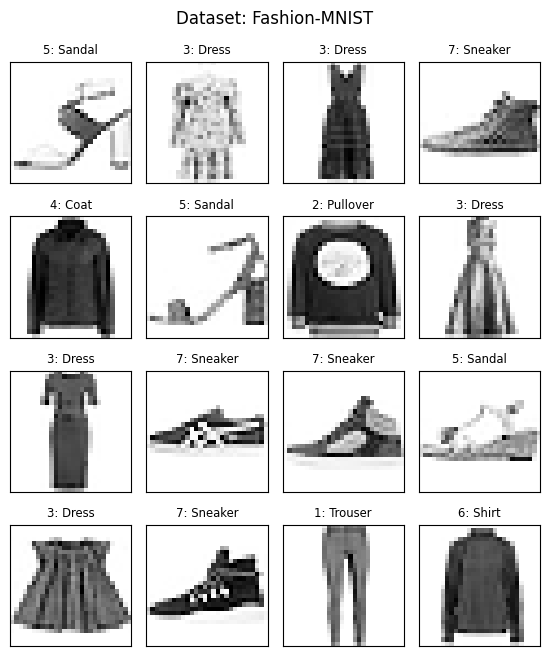

In [ ]:
### download data:

fmnist = datasets.FashionMNIST(root='data/', download=True)
fmnist.name, fmnist.num_classes = 'Fashion-MNIST', len(fmnist.classes)

### take a look:
count_labels(fmnist)
inspect_dataset(fmnist)

Below, we set up the task-incremental scenario. I define a number of timesteps, and allocate a subset of the FMNIST classes to each step.

We will have a train/validation split for each step, as well as a final test set containing unseen data from all timesteps.

<sub>(this could also be framed as a class-incremental learning problem, but we are treating each classification problem as a different 'task' like in the meta-learning practical, with specific task heads, and task-index conditioning)</sub>

Time=0 | Task ID 0 | 10,200 train | 1,200 validation | 600 test


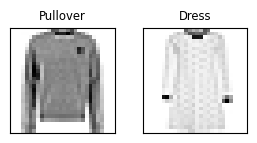

Time=1 | Task ID 1 | 10,200 train | 1,200 validation | 600 test


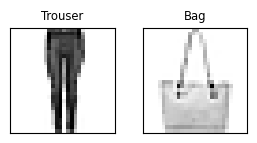

Time=2 | Task ID 2 | 15,300 train | 1,800 validation | 900 test


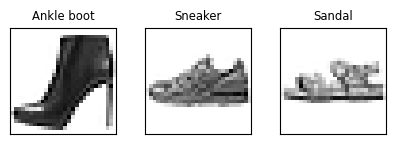

Time=3 | Task ID 3 | 15,300 train | 1,800 validation | 900 test


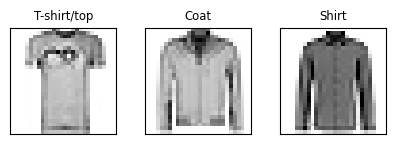

Final test set size (containing all tasks): 3,000

Joint training set size (containing all tasks): 51,000


In [ ]:
# divide the classes along different time steps:

timestep_task_classes = {
    0: ['Pullover', 'Dress'],
    1: ['Trouser', 'Bag'],
    2: ['Ankle boot', 'Sneaker', 'Sandal'],
    3: ['T-shirt/top', 'Coat', 'Shirt'],
    }

num_timesteps = len(timestep_task_classes)

# image preprocessing transform:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,))
])

# quick function for displaying the classes of a task:
def inspect_task(task_data, title=None):
    num_task_classes = len(task_data.classes)
    task_classes = tuple([str(c) for c in task_data.classes])

    class_image_examples = [[batch[0] for batch in task_data if batch[1]==c][0] for c in range(num_task_classes)]
    _ = inspect_batch(class_image_examples, labels=task_classes, scale=0.7, num_cols=num_task_classes, title=title, center_title=False)


# data/loader constants:
VAL_FRAC = 0.1     # validation hold-out per task
TEST_FRAC = 0.05   # for final test set containing all tasks
BATCH_SIZE = 256

# build task datasets for each timestep:
timestep_tasks = {}
timestep_loaders = {}

task_test_sets = []

for t, task_classes in timestep_task_classes.items():
    task_class_labels = [fmnist.class_to_idx[cl] for cl in task_classes] # original labels in fmnist source data
    task_datapoint_idxs = [i for i,label in enumerate(fmnist.targets) if label in task_class_labels]

    task_datapoints = [fmnist[idx] for idx in task_datapoint_idxs]

    class_to_idx = {task_classes[t]: t for t in range(len(task_classes))}

    task_images = [preprocess(img) for (img, label) in task_datapoints]
    task_labels = [class_to_idx[fmnist.classes[label]] for (img, label) in task_datapoints] # new labels

    # in addition to the images and labels, each task dataset now comes with a 'task id'
    # that tells the model which learned task to perform:
    task_ids = [t] * len(task_datapoints)

    task_image_tensor = torch.Tensor(torch.stack(task_images))
    task_label_tensor = torch.Tensor(task_labels).long()
    task_id_tensor = torch.Tensor(task_ids).long()

    task_data = TensorDataset(task_image_tensor, task_label_tensor, task_id_tensor)

    # train/validation split:
    train_frac  = 1.0 - VAL_FRAC - TEST_FRAC
    task_train, task_val, task_test = utils.data.random_split(task_data, [train_frac, VAL_FRAC, TEST_FRAC])

    # set dataset attributes to reflect what they contain:
    for data in (task_train, task_val, task_test):
        data.classes      = task_classes
        data.num_classes  = len(task_classes)
        data.class_to_idx = class_to_idx
        data.task_id      = t

    # inspect samples of both classes:
    print(f'Time={t} | Task ID {t} | {len(task_train):,} train | {len(task_val):,} validation | {len(task_test):,} test')
    inspect_task(task_train)

    # add train/val data to timestep dict, and test data to the list of test sets
    timestep_tasks[t] = task_train, task_val
    task_test_sets.append(task_test)


# for final evaluation of the model, we evaluate on all task test sets jointly:
final_test_data = ConcatDataset(task_test_sets)
final_test_loader = DataLoader(final_test_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
print(f'Final test set size (containing all tasks): {len(final_test_data):,}\n')


# and we will also run a joint training loop on the whole training dataset at once to see upper bound performance
joint_train_data = ConcatDataset([train for train,val in timestep_tasks.values()])
joint_train_loader = DataLoader(joint_train_data,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

print(f'Joint training set size (containing all tasks): {len(joint_train_data):,}')


In [ ]:
# we can verify that drawing a sample from this data produces a (image, label, task_id) triplet:

example = task_train[0]
image, label, task_id = example

print(f'\n image: {type(image)}  of shape {image.shape}')

print(f'\n label: {label}   (class: {task_train.classes[label]})')

print(f'\n task id: {task_id}   (classification between: {timestep_task_classes[int(task_id)]})')



 image: <class 'torch.Tensor'>  of shape torch.Size([1, 28, 28])

 label: 1   (class: Coat)

 task id: 3   (classification between: ['T-shirt/top', 'Coat', 'Shirt'])


## Models

Here we define the model classes we will use.

The dataset images are small, and monochrome, so we can get away with a small hand-built CNN backbone instead of a fancy pre-built model, defined as `ConvBackbone` below.

We'll also use a separate `TaskHead` class for the specific classification heads, like in previous practicals. This will be a helpful abstraction for dealing with the discrete tasks in our TIL setting.

And finally, we define a `MultitaskModel` that combines the backbone with multiple task heads, and incorporates the 'task ID' routing in its `forward` method that allows task heads to be called selectively depending on the input task.



In [ ]:
### model architecture hyperparameters:
NUM_CONV_FEATURES = [32, 64, 64, 128]
TASK_HEAD_PROJECTION_SIZE = 64
INPUT_SIZE = (1,28,28) # for grayscale images

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Conv4Backbone(nn.Module):
    def __init__(self,
                 layers=NUM_CONV_FEATURES, # list of conv layer num_kernels
                 input_size=INPUT_SIZE,
                 device=device,
                ):
        super().__init__()

        in_channels, in_h, in_w = input_size

        # build the sequential stack of conv layers:
        conv_layers = []
        prev_layer_size = in_channels
        for layer_size in layers:
            conv_layers.append(nn.Conv2d(prev_layer_size, layer_size, (3,3), padding='same'))
            conv_layers.append(nn.GroupNorm(num_groups=layer_size//4, num_channels=layer_size))
            conv_layers.append(nn.ReLU())
            prev_layer_size = layer_size

        self.conv_stack = torch.nn.Sequential(*conv_layers)

        # global average pooling to reduce to single dimension:
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        # number of output features:
        self.num_features = prev_layer_size

        self.relu = nn.ReLU()

        self.device = device
        self.to(device)

    def forward(self, x):
        # pass through conv layers:
        x = self.conv_stack(x)

        # downsample and reshape to vector:
        x = self.pool(x)
        x = x.view(-1, self.num_features)

        # return feature vector:
        return x

### as before, define a classification head that we can attach to the backbone:
class TaskHead(nn.Module):
    def __init__(self,
                 num_classes: int,      # number of output neurons
                 input_size: int = NUM_CONV_FEATURES[-1], # number of features in the backbone's output
                 projection_size: int = TASK_HEAD_PROJECTION_SIZE,  # number of neurons in the hidden layer
                 dropout: float=0.,     # optional dropout rate to apply
                 device=device):
        super().__init__()

        self.projection = nn.Linear(input_size, projection_size)
        self.classifier = nn.Linear(projection_size, num_classes)

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.Identity()

        self.relu = nn.ReLU()

        self.device = device
        self.to(device)

    def forward(self, x):
        # assume x is already unactivated feature logits,
        # e.g. from resnet backbone
        x = self.projection(self.relu(self.dropout(x)))
        x = self.classifier(self.relu(self.dropout(x)))

        return x


### and a model that contains a backbone plus multiple class heads,
### and performs task-ID routing at runtime, allowing it to perform any learned task:
class MultitaskModel(nn.Module):
    def __init__(self, backbone: nn.Module,
                 device=device):
        super().__init__()

        self.backbone = backbone

        # a dict mapping task IDs to the classification heads for those tasks:
        self.task_heads = nn.ModuleDict()
        # we must use a nn.ModuleDict instead of a base python dict,
        # to ensure that the modules inside are properly registered in self.parameters() etc.

        self.relu = nn.ReLU()
        self.device = device
        self.to(device)

    def forward(self,
                x: torch.Tensor,
                task_id: int):

        task_id = str(int(task_id))
        # nn.ModuleDict requires string keys for some reason,
        # so we have to be sure to cast the task_id from tensor(2) to 2 to '2'

        assert task_id in self.task_heads, f"no head exists for task id {task_id}"

        # select which classifier head to use:
        chosen_head = self.task_heads[task_id]

        # activated features from backbone:
        x = self.relu(self.backbone(x))
        # task-specific prediction:
        x = chosen_head(x)

        return x

    def add_task(self,
                 task_id: int,
                 head: nn.Module):
        """accepts an integer task_id and a classification head
        associated to that task.
        adds the head to this model's collection of task heads."""
        self.task_heads[str(task_id)] = head.to(self.device)

    @property
    def num_task_heads(self):
        return len(self.task_heads)

## Baseline Training

As a baseline, we'll perform 'basic' transfer learning (without any specific CL algorithm) by simply training on the data at each time-step as it comes in, adding a new task head when necessary.

Below are functions to evaluate the multitask model on a specific validation loader, as well as a final test function that performs this evaluation across the test set for all tasks seen so far:

In [ ]:

#### basic evaluation function for a multitask model
#### over some specified validation loader,
#### expecting the correct task IDs:
def evaluate_model(multitask_model: nn.Module,  # trained model capable of multi-task classification
                   val_loader: utils.data.DataLoader,  # task-specific data to evaluate on
                   loss_fn: nn.modules.loss._Loss = nn.CrossEntropyLoss(),
                  ):
    """runs model on entirety of validation loader,
    with specified loss and accuracy functions,
    and returns average loss/acc over all batches"""
    multitask_model.eval()
    with torch.no_grad():
        batch_val_losses, batch_val_accs = [], []

        for batch in val_loader:
            vx, vy, task_ids = batch
            vx, vy = vx.to(device), vy.to(device)

            vpred = multitask_model(vx, task_ids[0])
            val_loss = loss_fn(vpred, vy)
            val_acc = top1_acc(vpred, vy)

            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
    return np.mean(batch_val_losses), np.mean(batch_val_accs)


#### we will also evaluate the model on the test sets of all the tasks seen so far,
#### which also lets us see the final overall performance at the end of the run
def full_test_evaluate(multitask_model: nn.Module,   # trained model capable of multi-task classification
                  selected_test_sets: list[utils.data.Dataset], # task-specific test sets to evaluate on
                  prev_accs: list[list[float]] = None, # previous taskwise accuracies of this model,
                                                       # to show catastrophic forgetting gaps
                  show_taskwise_accuracy=True, # show bar plot indicating performance on each separate task
                  baseline_taskwise_accs: list[float]=None, # optional baseline performance on each task for comparison
                  model_name: str='', # optional model name to show in plots
                  verbose=False, # more detailed output to console
                 ):
    if verbose:
        print(f'{model_name} evaluation on test set of all tasks:'.capitalize())

    task_test_losses = []
    task_test_accs = []

    for t, test_data in enumerate(selected_test_sets):
        test_loader = utils.data.DataLoader(test_data,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)

        task_test_loss, task_test_acc = evaluate_model(multitask_model, test_loader)

        if verbose:
            print(f'{test_data.classes}: {task_test_acc:.2%}')
            if baseline_taskwise_accs is not None:
                print(f'(baseline: {baseline_taskwise_accs[t]:.2%})')

        task_test_losses.append(task_test_loss)
        task_test_accs.append(task_test_acc)

    avg_task_test_loss = np.mean(task_test_losses)
    avg_task_test_acc = np.mean(task_test_accs)

    if verbose:
        print(f'\n +++ AVERAGE TASK TEST ACCURACY: {avg_task_test_acc:.2%} +++ ')


    if show_taskwise_accuracy:
        bar_heights = task_test_accs + [0]*(len(task_test_sets) - len(selected_test_sets))
        # display bar plot with accuracy on each evaluation task
        plt.bar(x = range(len(task_test_sets)), height=bar_heights, zorder=1, alpha=0.9)
        plt.xticks(range(len(task_test_sets)), [',\n'.join(task.classes) for task in task_test_sets]) #, rotation='vertical')
        plt.axhline(avg_task_test_acc, c=[0.2]*3, linestyle=':')
        plt.text(1, avg_task_test_acc+0.01, f'{model_name} (average)', c=[0.2]*3, size=8)

        if prev_accs is not None:
            # plot the previous step's accuracies on top
            # (will show forgetting in red)
            for p, prev_acc_list in enumerate(prev_accs):
                plt.bar(x = range(len(prev_acc_list)), height=prev_acc_list, fc='tab:red', zorder=0, alpha=0.5*((p+1)/len(prev_accs)))

        if baseline_taskwise_accs is not None:
            for t, acc in enumerate(baseline_taskwise_accs):
                plt.plot([t-0.4, t+0.4], [acc, acc], c=[0.6]*3, linestyle='--', label=f'baseline at t={len(baseline_taskwise_accs)-1}' if t==0 else None)
            plt.legend()
            # show average as well:
            baseline_avg = np.mean(baseline_taskwise_accs)
            plt.axhline(baseline_avg, c=[0.6]*3, linestyle=':')
            plt.text(1, baseline_avg-0.025, f'baseline at t={len(baseline_taskwise_accs)-1} (average)', c=[0.6]*3, size=8)

        plt.title(f'{model_name}: Test-time evaluation on all known tasks')
        plt.show()

    return task_test_accs

Finally, we define the continual learning training loop here.
- We set some hyperparameters and do an outer loop over each timestep, drawing the appropriate data for each timestep.
- Inside each timestep, we define a head for the current task, and perform a normal model training loop on that task.
  - Note that our `multitask_model` requires a task index as well as an input tensor to perform the forward pass. The task index tells the model which task head to route the backbone's output into.
- The task-specific training updates the model backbone together with the new task head, but leaves heads for previous tasks unchanged.

Training on task id: 0  (classification between: ['Pullover', 'Dress'])


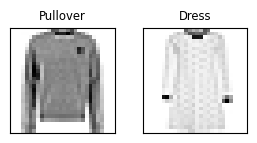

  Adding new task head 0 to multi-task model


E0 batch loss:0.31, batch acc:95.4%: 100%|██████████████████████████| 40/40 [00:03<00:00, 11.60it/s]


epoch:  0 | loss: 0.46 | 0.33   acc: 83.8% | 92.5%


E1 batch loss:0.26, batch acc:94.9%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.80it/s]


epoch:  1 | loss: 0.27 | 0.25   acc: 94.9% | 95.7%


E2 batch loss:0.23, batch acc:95.4%: 100%|██████████████████████████| 40/40 [00:02<00:00, 17.96it/s]


epoch:  2 | loss: 0.24 | 0.22   acc: 95.5% | 96.1%


E3 batch loss:0.22, batch acc:94.0%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.81it/s]


epoch:  3 | loss: 0.21 | 0.22   acc: 96.2% | 94.8%


E4 batch loss:0.20, batch acc:96.3%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.83it/s]


epoch:  4 | loss: 0.20 | 0.19   acc: 96.2% | 96.1%


E5 batch loss:0.16, batch acc:96.3%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.78it/s]


epoch:  5 | loss: 0.18 | 0.18   acc: 96.9% | 96.3%


E6 batch loss:0.16, batch acc:97.7%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.69it/s]


epoch:  6 | loss: 0.19 | 0.18   acc: 95.9% | 96.5%


E7 batch loss:0.17, batch acc:96.3%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.30it/s]


epoch:  7 | loss: 0.16 | 0.17   acc: 97.1% | 95.9%


E8 batch loss:0.19, batch acc:94.9%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.53it/s]


epoch:  8 | loss: 0.16 | 0.16   acc: 96.6% | 96.4%


E9 batch loss:0.13, batch acc:97.2%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.76it/s]


epoch:  9 | loss: 0.16 | 0.15   acc: 96.8% | 96.6%


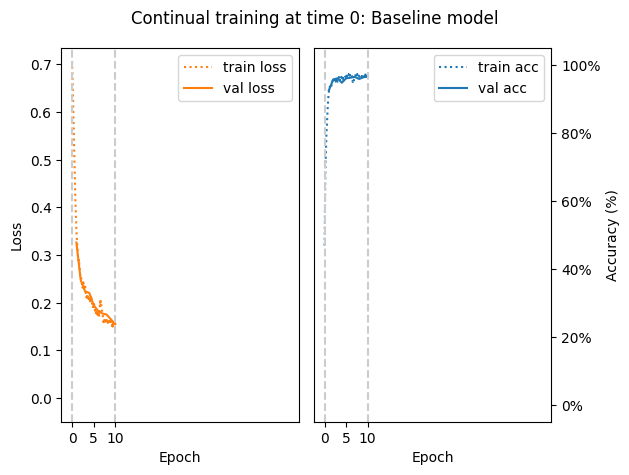

Baseline at t=0 evaluation on test set of all tasks:
['Pullover', 'Dress']: 98.44%

 +++ AVERAGE TASK TEST ACCURACY: 98.44% +++ 


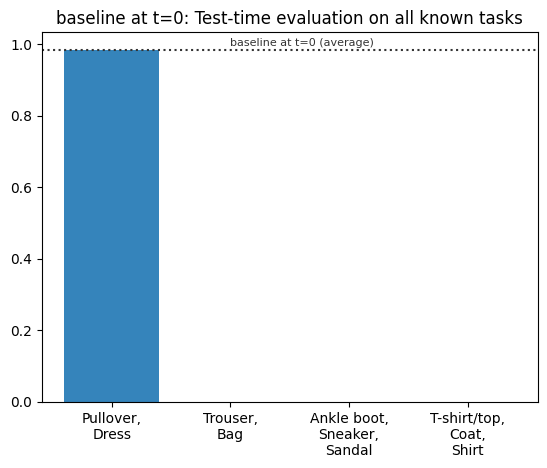

Training on task id: 1  (classification between: ['Trouser', 'Bag'])


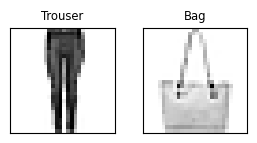

  Adding new task head 1 to multi-task model


E0 batch loss:0.27, batch acc:97.2%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.50it/s]


epoch:  0 | loss: 0.44 | 0.29   acc: 87.5% | 96.9%


E1 batch loss:0.18, batch acc:97.7%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.58it/s]


epoch:  1 | loss: 0.22 | 0.17   acc: 98.1% | 98.9%


E2 batch loss:0.13, batch acc:100.0%: 100%|█████████████████████████| 40/40 [00:02<00:00, 18.31it/s]


epoch:  2 | loss: 0.15 | 0.14   acc: 99.2% | 99.1%


E3 batch loss:0.11, batch acc:99.5%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.29it/s]


epoch:  3 | loss: 0.13 | 0.11   acc: 99.2% | 99.5%


E4 batch loss:0.12, batch acc:99.1%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


epoch:  4 | loss: 0.11 | 0.11   acc: 99.4% | 99.1%


E5 batch loss:0.11, batch acc:98.6%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.58it/s]


epoch:  5 | loss: 0.10 | 0.10   acc: 99.5% | 99.4%


E6 batch loss:0.10, batch acc:98.6%: 100%|██████████████████████████| 40/40 [00:02<00:00, 16.33it/s]


epoch:  6 | loss: 0.09 | 0.12   acc: 99.5% | 98.1%


E7 batch loss:0.07, batch acc:100.0%: 100%|█████████████████████████| 40/40 [00:02<00:00, 17.29it/s]


epoch:  7 | loss: 0.09 | 0.08   acc: 99.5% | 99.6%


E8 batch loss:0.08, batch acc:99.5%: 100%|██████████████████████████| 40/40 [00:02<00:00, 18.26it/s]


epoch:  8 | loss: 0.08 | 0.08   acc: 99.4% | 99.5%


E9 batch loss:0.06, batch acc:100.0%: 100%|█████████████████████████| 40/40 [00:02<00:00, 18.68it/s]


epoch:  9 | loss: 0.07 | 0.07   acc: 99.5% | 99.7%


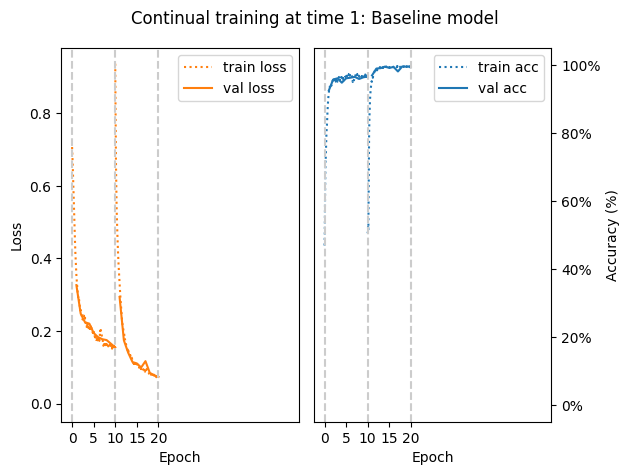

Baseline at t=1 evaluation on test set of all tasks:
['Pullover', 'Dress']: 49.37%
['Trouser', 'Bag']: 99.74%

 +++ AVERAGE TASK TEST ACCURACY: 74.56% +++ 


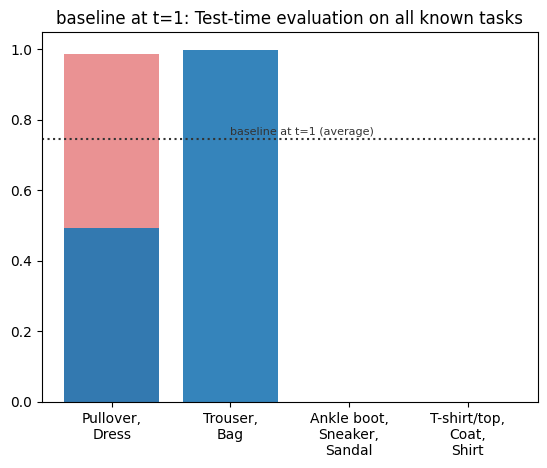

Training on task id: 2  (classification between: ['Ankle boot', 'Sneaker', 'Sandal'])


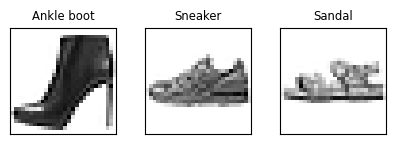

  Adding new task head 2 to multi-task model


E0 batch loss:0.57, batch acc:83.2%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.64it/s]


epoch:  0 | loss: 0.83 | 0.57   acc: 67.6% | 82.3%


E1 batch loss:0.44, batch acc:85.2%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.23it/s]


epoch:  1 | loss: 0.51 | 0.44   acc: 84.2% | 87.5%


E2 batch loss:0.40, batch acc:86.7%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.38it/s]


epoch:  2 | loss: 0.43 | 0.37   acc: 87.2% | 89.0%


E3 batch loss:0.33, batch acc:91.8%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.56it/s]


epoch:  3 | loss: 0.36 | 0.36   acc: 89.9% | 90.6%


E4 batch loss:0.32, batch acc:91.3%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.40it/s]


epoch:  4 | loss: 0.31 | 0.27   acc: 91.4% | 92.8%


E5 batch loss:0.35, batch acc:89.3%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.15it/s]


epoch:  5 | loss: 0.30 | 0.27   acc: 91.5% | 92.2%


E6 batch loss:0.28, batch acc:91.8%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.57it/s]


epoch:  6 | loss: 0.28 | 0.27   acc: 91.8% | 92.1%


E7 batch loss:0.25, batch acc:93.9%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.49it/s]


epoch:  7 | loss: 0.28 | 0.27   acc: 91.5% | 91.2%


E8 batch loss:0.23, batch acc:93.9%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.36it/s]


epoch:  8 | loss: 0.24 | 0.28   acc: 93.2% | 91.6%


E9 batch loss:0.27, batch acc:89.3%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.22it/s]


epoch:  9 | loss: 0.24 | 0.22   acc: 93.3% | 93.5%


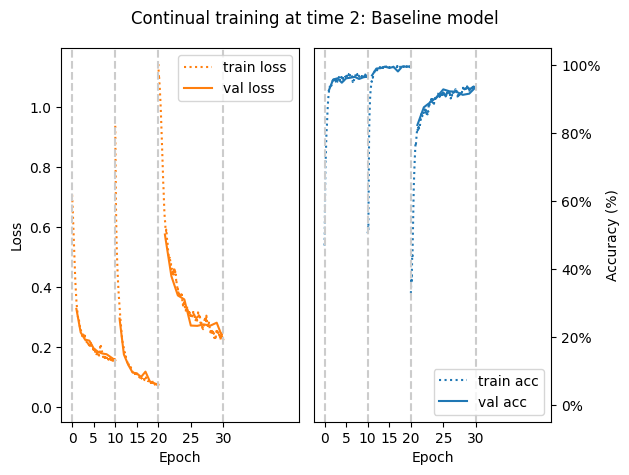

Baseline at t=2 evaluation on test set of all tasks:
['Pullover', 'Dress']: 59.53%
['Trouser', 'Bag']: 51.11%
['Ankle boot', 'Sneaker', 'Sandal']: 92.81%

 +++ AVERAGE TASK TEST ACCURACY: 67.82% +++ 


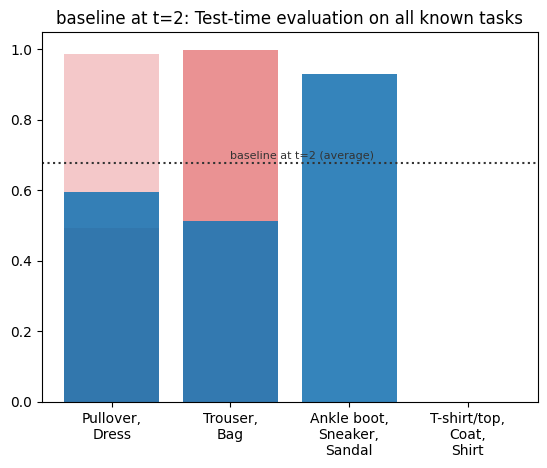

Training on task id: 3  (classification between: ['T-shirt/top', 'Coat', 'Shirt'])


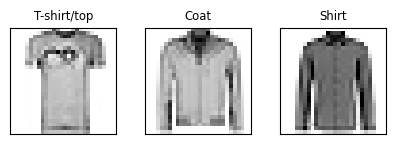

  Adding new task head 3 to multi-task model


E0 batch loss:0.94, batch acc:54.6%: 100%|██████████████████████████| 60/60 [00:03<00:00, 17.40it/s]


epoch:  0 | loss: 1.03 | 0.92   acc: 50.7% | 58.9%


E1 batch loss:0.74, batch acc:76.0%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.36it/s]


epoch:  1 | loss: 0.83 | 0.76   acc: 66.5% | 70.7%


E2 batch loss:0.67, batch acc:75.0%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.33it/s]


epoch:  2 | loss: 0.71 | 0.63   acc: 71.2% | 77.2%


E3 batch loss:0.62, batch acc:77.0%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.48it/s]


epoch:  3 | loss: 0.65 | 0.64   acc: 73.8% | 78.2%


E4 batch loss:0.63, batch acc:74.5%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.46it/s]


epoch:  4 | loss: 0.62 | 0.57   acc: 75.0% | 79.1%


E5 batch loss:0.55, batch acc:81.1%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.03it/s]


epoch:  5 | loss: 0.59 | 0.54   acc: 76.3% | 80.7%


E6 batch loss:0.50, batch acc:85.2%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.44it/s]


epoch:  6 | loss: 0.56 | 0.51   acc: 77.4% | 81.3%


E7 batch loss:0.49, batch acc:82.7%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.39it/s]


epoch:  7 | loss: 0.54 | 0.49   acc: 78.2% | 82.2%


E8 batch loss:0.44, batch acc:84.7%: 100%|██████████████████████████| 60/60 [00:03<00:00, 18.44it/s]


epoch:  8 | loss: 0.52 | 0.55   acc: 79.4% | 77.8%


E9 batch loss:0.48, batch acc:82.1%: 100%|██████████████████████████| 60/60 [00:03<00:00, 17.98it/s]


epoch:  9 | loss: 0.51 | 0.45   acc: 79.7% | 84.7%


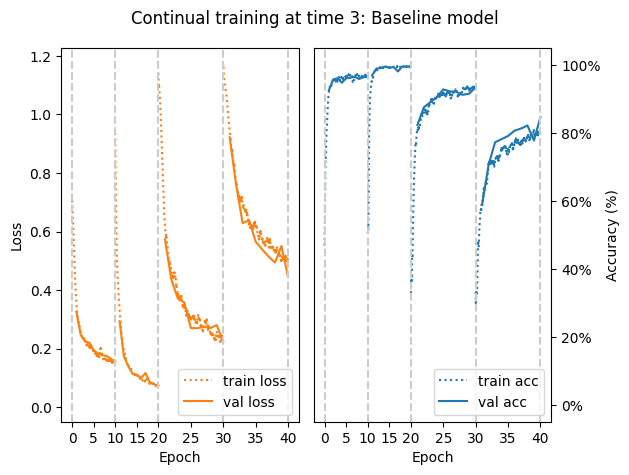

Baseline at t=3 evaluation on test set of all tasks:
['Pullover', 'Dress']: 50.64%
['Trouser', 'Bag']: 49.37%
['Ankle boot', 'Sneaker', 'Sandal']: 52.56%
['T-shirt/top', 'Coat', 'Shirt']: 82.96%

 +++ AVERAGE TASK TEST ACCURACY: 58.88% +++ 


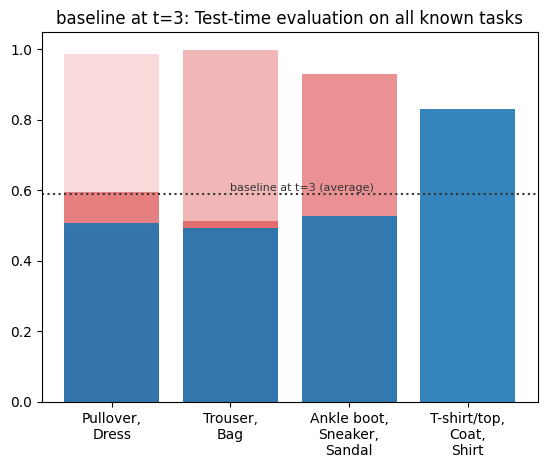


=== Baseline final accuracy averaged over all test tasks: 58.88% ===


In [ ]:
torch.manual_seed(0)

# define backbone and place it inside the multitask model:
backbone = Conv4Backbone()
multitask_model = MultitaskModel(backbone)

# CL hyperparameters:
epochs_per_timestep = 10    # how many epochs to run before switching to next task

### training hyperparameters:
lr     = 1e-3  # initial learning rate
l2_reg = 1e-4  # L2 weight decay term (0 means no regularisation)

### metrics and plotting:
dynamic_plot  = False   # show training plots after each timestep
show_progress = True   # show progress bars and end-of-epoch metrics
verbose       = True   # output extra info to console


# define loss and optimiser:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(multitask_model.parameters(), lr=lr, weight_decay=l2_reg)

# some variables for plotting:
metrics = TrainingMetrics()
baseline_prev_test_accs = [] # test accuracy on previous tasks, to monitor forgetting
total_train_steps = int(sum([epochs_per_timestep * np.ceil(len(train_set)/BATCH_SIZE)
                                 for (train_set, val_set) in timestep_tasks.values()]))

# outer loop over each task, in sequence
for t, (task_train, task_val) in timestep_tasks.items():

    if verbose:
        print(f'Training on task id: {t}  (classification between: {task_train.classes})')
        inspect_task(task_train)

    if t not in multitask_model.task_heads:
        if verbose:
            print(f'  Adding new task head {t} to multi-task model')

        task_head = TaskHead(num_classes = task_train.num_classes)
        multitask_model.add_task(t, task_head)

    # build train and validation loaders for the current task:
    train_loader, val_loader = [utils.data.DataLoader(data,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)
                                for data in (task_train, task_val)]

    # inner loop over the current task:
    for e in range(epochs_per_timestep):
        epoch_train_losses, epoch_train_accs = [], []

        if show_progress:
            # set a progress bar to loop over
            batch_iter = tqdm(train_loader, ncols=100)
        else:
            batch_iter = train_loader

        multitask_model.train()
        for step, batch in enumerate(batch_iter):
            # get the image-label pair from the dataloader batch,
            # along with the task ID, which should be the same number across the whole batch
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)

            opt.zero_grad()

            # verify that task IDs are all the same, just in case:
            assert torch.all(task_ids == task_ids[0]), "mismatching task IDs within batch"
            task_id = task_ids[0]

            pred = multitask_model(x, task_id) # important to send task ID to the model!

            batch_loss = loss_fn(pred, y)
            batch_acc = top1_acc(pred, y)

            batch_loss.backward()
            opt.step()

            # track loss and accuracy:
            metrics.log_train(loss=batch_loss.item(), acc=batch_acc)


            if show_progress:
                # show loss/acc of this batch in progress bar:
                report = (f'E{e} batch loss:{batch_loss:.2f}, batch acc:{batch_acc:>5.1%}')
                batch_iter.set_description(report)

        # evaluate after each epoch::
        val_loss, val_acc = evaluate_model(multitask_model, val_loader, loss_fn)
        metrics.log_val(loss=val_loss, acc=val_acc)

        # report summary metrics:
        epoch_train_loss, epoch_val_loss = metrics.epoch_loss
        epoch_train_acc, epoch_val_acc = metrics.epoch_acc
        print(f'epoch:{e:>3} | loss: {epoch_train_loss:.2f} | {epoch_val_loss:.2f}   ' +
          f'acc: {epoch_train_acc:.1%} | {epoch_val_acc:.1%}')

    metrics.next_iteration() # increment CL timestep for plotting

    metrics.plot(title=f'Continual training at time {t}: Baseline model', live=False,
                 max_step = total_train_steps)

    # evaluate on all tasks so far, and save the performance:
    task_test_accs = full_test_evaluate(multitask_model, task_test_sets[:t+1], model_name=f'baseline at t={t}',
                                        prev_accs = baseline_prev_test_accs, verbose=True)
    baseline_prev_test_accs.append(task_test_accs)

# record the baseline performance for later comparison with your CL implementation
baseline_metrics = metrics
baseline_taskwise_test_accs = task_test_accs

baseline_avg_test_acc = np.mean(baseline_taskwise_test_accs)
print(f'\n=== Baseline final accuracy averaged over all test tasks: {baseline_avg_test_acc:.2%} ===')


At the end, we have the evaluation on the final test set, which contains all the tasks encountered so far.

We can see that despite achieving good accuracy on each task as the model trains, the final accuracy over all tasks is quite bad! The red areas on the bar chart indicate where catastrophic forgetting has occurred.

Your objective is to fix this catastrophic forgetting, while maintaining the setting where data from previous tasks is not available at each time step.

### Task: Continual Learning with LwF

To improve the test performance, you will implement the Learning-without-Forgetting algorithm for continual learning.

Recall this diagram from the lectures:

![lwf_in_context](https://i.imgur.com/J6OxV4V.png)

So far, the baseline implemented above is an example of case **(b)**. That is, naïvely fine-tuning the backbone together with the new task head; leaving the previous task head(s) unchanged, but modifying the backbone such that what it sends to the previous task head(s) may no longer make sense. We can see that this ruins the performance on previous tasks.

If we had access to previous data, we could mix this into the training at each time step. However, in this **incremental learning** setting we have only the data at the current time step.

LwF tries to preserve performance on previous tasks without having to store any of the old data.
- Instead, it requires us only to store the previous state of the model at the last time step.
- It adds an extra constraint in the form of a diffusion loss term for the previous task heads.
- This diffusion loss is calculated as the distance between the output distribution of the old and new model on each task (averaged across tasks)
- Effectively, the previous model is acting as a teacher for the current model, but only for the tasks that the current model cannot see.

The algorithm is formulated like this:

![lwf_algorithm](https://i.imgur.com/N07IT1M.png)

For each example, we calculate the joint loss, including:

- $L_{\textit{new}} (Y_n, \hat{Y}_n)$ is normal cross-entropy loss between the ground truth $Y_n$ and the prediction $\hat{Y}_n$ on the **current task head**.

- $L_{\textit{old}} (Y_o, \hat{Y}_o) $ is the **distillation loss** between the previous model's output $Y_o$ and the current model's output $\hat{Y}_o$ on **previous task heads**.

- $ \lambda_o $ is a **stability** term that controls the stability-plasticity tradeoff.

- $ R(\hat{\theta}_s, \hat{\theta}_o, \hat{\theta}_n) $ is the usual L2 weight decay regularisation term.



The distillation loss is exactly the same as what you implemented in practical 2 for knowledge distillation. You're all familiar with this already, so you can just use the `distillation_output_loss` implemented below:

In [ ]:
def temperature_softmax(x, T):
    """applies softmax over channel dimension
    after re-scaling by chosen temperature arg T.
    returns a probability distribution of shape (batch, num_classes)"""
    return torch.softmax(x / T, dim=1)

def KL_divergence(p, q):
    """a measure of distance between two probability distributions.
    returns a positive scalar."""
    return torch.sum(p * torch.log(p / q), dim=-1)

def distillation_output_loss(student_pred, teacher_pred, temperature):
    """accepts unscaled logits from student and teacher model
    applies temperature-scaled softmax, and returns distillation loss
    as the KL-divergence between them, per example in the batch.
    output is a tensor of shape (batch,)"""

    student_soft = temperature_softmax(student_pred, temperature)
    teacher_soft = temperature_softmax(teacher_pred, temperature)

    kl_div = KL_divergence(student_soft, teacher_soft)

    return kl_div * temperature**2

Now, the rest is up to you. Implement the LwF algorithm on top of the continual-learning loop we used for the baseline earlier. Copy it and modify if you want. I have left some skeleton code below that will help with plotting the results, but the rest is up to you.

Some tips:
- The distillation loss above will be the soft 'stability loss' you add in each training step. You can record this quantity for the training metrics within `metrics.log_train`
  
- As you know, you can use a `temperature` term to control the softness of the teacher->student supervision. Try setting it to a similar value to whatever worked for you in the knowledge distillation practical.
  
- You might also find it useful to define a `stability_weight` parameter to balance this soft loss with the usual hard label loss for the current classification task. How you define this parameter is up to you, but you may need to experiment with it to find a good trade-off between learning and forgetting.

- In particular, pay attention to the size of the stability term compared to the hard loss term; how this stability loss accumulates as new tasks are added; and how adding or averaging these losses interacts with the effective learning rate.
  
- Feel free to change the number of epochs trained inside each timestep, or the other training hyperparameters - but for a fair comparison with the baseline, you should make the same change there as well, to ensure that any improvement in your method is due to the CL algorithm and not due to different training scenarios.

Training on task id: 0  (classes: ['Pullover', 'Dress'])


E0 loss=0.307 acc=95.37%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.25it/s]


epoch:0/10 | loss: 0.4632 | val_loss:0.3263  acc: 83.76% | val_acc: 92.52%


E1 loss=0.255 acc=94.91%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.42it/s]


epoch:1/10 | loss: 0.2719 | val_loss:0.2476  acc: 94.90% | val_acc: 95.80%


E2 loss=0.222 acc=95.83%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.92it/s]


epoch:2/10 | loss: 0.2334 | val_loss:0.2365  acc: 95.58% | val_acc: 94.64%


E3 loss=0.212 acc=95.37%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.53it/s]


epoch:3/10 | loss: 0.2082 | val_loss:0.2045  acc: 96.32% | val_acc: 96.23%


E4 loss=0.191 acc=96.76%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.61it/s]


epoch:4/10 | loss: 0.1923 | val_loss:0.1951  acc: 96.65% | val_acc: 96.12%


E5 loss=0.149 acc=98.61%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.73it/s]


epoch:5/10 | loss: 0.1745 | val_loss:0.1774  acc: 97.10% | val_acc: 96.61%


E6 loss=0.160 acc=97.69%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.66it/s]


epoch:6/10 | loss: 0.1679 | val_loss:0.1720  acc: 97.07% | val_acc: 96.74%


E7 loss=0.158 acc=97.22%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.16it/s]


epoch:7/10 | loss: 0.1642 | val_loss:0.1648  acc: 96.76% | val_acc: 96.46%


E8 loss=0.130 acc=99.07%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.31it/s]


epoch:8/10 | loss: 0.1525 | val_loss:0.1599  acc: 97.09% | val_acc: 96.70%


E9 loss=0.162 acc=96.30%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.56it/s]


epoch:9/10 | loss: 0.1488 | val_loss:0.1537  acc: 97.09% | val_acc: 96.40%


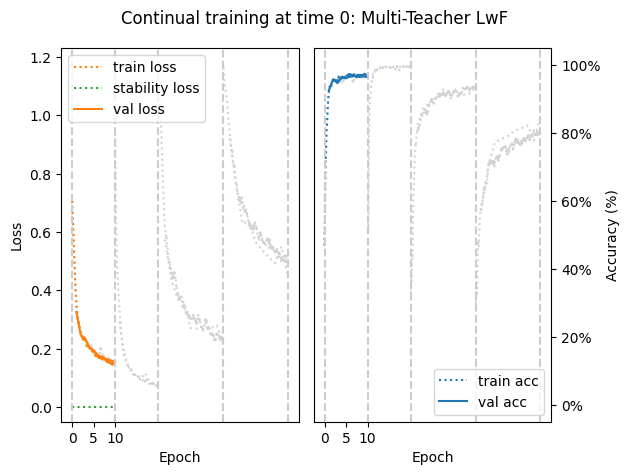

Multi-teacher lwf at t=0 evaluation on test set of all tasks:
['Pullover', 'Dress']: 98.31%
(baseline: 98.44%)

 +++ AVERAGE TASK TEST ACCURACY: 98.31% +++ 


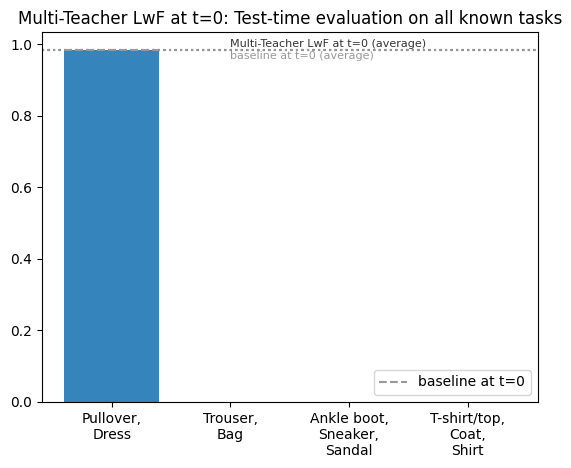

Training on task id: 1  (classes: ['Trouser', 'Bag'])


E0 loss=0.439 acc=95.83%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.26it/s]


epoch:0/10 | loss: 0.4914 | val_loss:0.3089  acc: 78.75% | val_acc: 95.92%


E1 loss=0.374 acc=98.15%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.21it/s]


epoch:1/10 | loss: 0.2474 | val_loss:0.2105  acc: 97.03% | val_acc: 97.98%


E2 loss=0.317 acc=100.00%: 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.22it/s]


epoch:2/10 | loss: 0.1816 | val_loss:0.1734  acc: 98.87% | val_acc: 98.05%


E3 loss=0.298 acc=99.07%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.19it/s]


epoch:3/10 | loss: 0.1556 | val_loss:0.1428  acc: 98.84% | val_acc: 99.11%


E4 loss=0.289 acc=99.54%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.04it/s]


epoch:4/10 | loss: 0.1334 | val_loss:0.1281  acc: 99.22% | val_acc: 99.23%


E5 loss=0.295 acc=98.15%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.17it/s]


epoch:5/10 | loss: 0.1184 | val_loss:0.1157  acc: 99.39% | val_acc: 99.23%


E6 loss=0.257 acc=99.54%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.21it/s]


epoch:6/10 | loss: 0.1075 | val_loss:0.1060  acc: 99.42% | val_acc: 99.23%


E7 loss=0.234 acc=100.00%: 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.13it/s]


epoch:7/10 | loss: 0.0978 | val_loss:0.0963  acc: 99.49% | val_acc: 99.50%


E8 loss=0.260 acc=98.15%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.17it/s]


epoch:8/10 | loss: 0.0923 | val_loss:0.0892  acc: 99.45% | val_acc: 99.57%


E9 loss=0.217 acc=100.00%: 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.10it/s]


epoch:9/10 | loss: 0.0838 | val_loss:0.0837  acc: 99.53% | val_acc: 99.57%


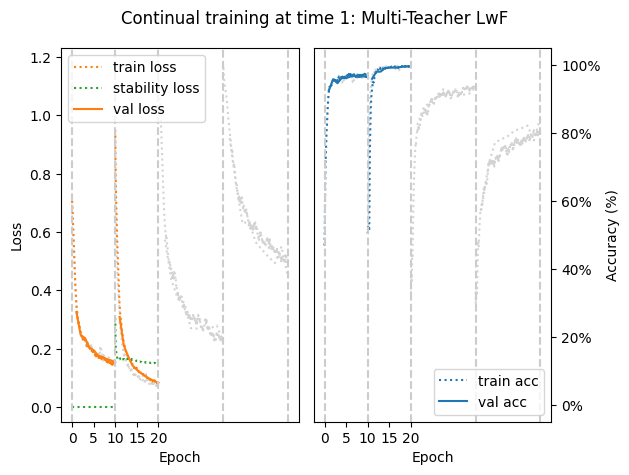

Multi-teacher lwf at t=1 evaluation on test set of all tasks:
['Pullover', 'Dress']: 97.41%
(baseline: 49.37%)
['Trouser', 'Bag']: 99.61%
(baseline: 99.74%)

 +++ AVERAGE TASK TEST ACCURACY: 98.51% +++ 


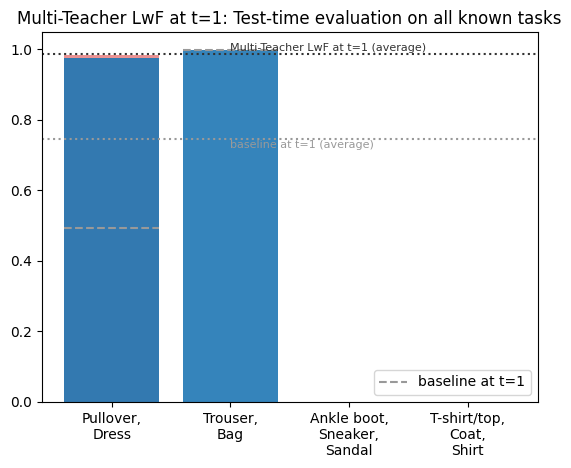

Training on task id: 2  (classes: ['Ankle boot', 'Sneaker', 'Sandal'])


E0 loss=0.763 acc=81.63%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.68it/s]


epoch:0/10 | loss: 0.8118 | val_loss:0.6488  acc: 69.99% | val_acc: 78.81%


E1 loss=0.600 acc=86.22%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.67it/s]


epoch:1/10 | loss: 0.5344 | val_loss:0.4702  acc: 84.13% | val_acc: 85.94%


E2 loss=0.567 acc=86.22%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.53it/s]


epoch:2/10 | loss: 0.4625 | val_loss:0.4343  acc: 86.44% | val_acc: 85.89%


E3 loss=0.492 acc=92.35%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.64it/s]


epoch:3/10 | loss: 0.3882 | val_loss:0.3984  acc: 89.48% | val_acc: 89.79%


E4 loss=0.492 acc=89.80%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.66it/s]


epoch:4/10 | loss: 0.3552 | val_loss:0.3320  acc: 90.25% | val_acc: 91.21%


E5 loss=0.505 acc=88.78%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.66it/s]


epoch:5/10 | loss: 0.3361 | val_loss:0.2895  acc: 90.62% | val_acc: 92.82%


E6 loss=0.459 acc=89.29%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.67it/s]


epoch:6/10 | loss: 0.3135 | val_loss:0.3129  acc: 91.16% | val_acc: 92.38%


E7 loss=0.401 acc=92.86%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.68it/s]


epoch:7/10 | loss: 0.2863 | val_loss:0.2679  acc: 91.91% | val_acc: 92.33%


E8 loss=0.373 acc=93.37%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.65it/s]


epoch:8/10 | loss: 0.2685 | val_loss:0.2937  acc: 92.51% | val_acc: 91.11%


E9 loss=0.370 acc=94.39%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.65it/s]


epoch:9/10 | loss: 0.2615 | val_loss:0.2346  acc: 92.41% | val_acc: 93.85%


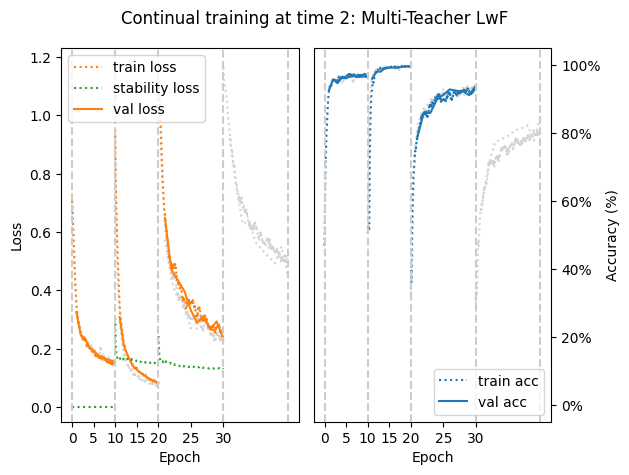

Multi-teacher lwf at t=2 evaluation on test set of all tasks:
['Pullover', 'Dress']: 55.92%
(baseline: 59.53%)
['Trouser', 'Bag']: 51.11%
(baseline: 51.11%)
['Ankle boot', 'Sneaker', 'Sandal']: 93.50%
(baseline: 92.81%)

 +++ AVERAGE TASK TEST ACCURACY: 66.84% +++ 


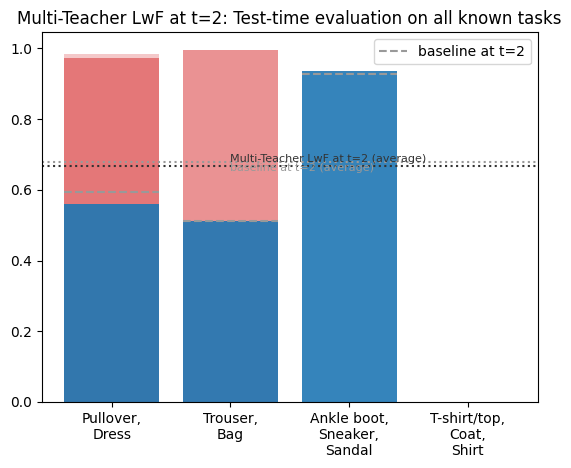

Training on task id: 3  (classes: ['T-shirt/top', 'Coat', 'Shirt'])


E0 loss=1.061 acc=52.04%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]


epoch:0/10 | loss: 0.9939 | val_loss:0.9203  acc: 53.41% | val_acc: 61.67%


E1 loss=0.878 acc=70.92%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]


epoch:1/10 | loss: 0.8231 | val_loss:0.7676  acc: 66.37% | val_acc: 68.90%


E2 loss=0.822 acc=75.51%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:2/10 | loss: 0.7288 | val_loss:0.6746  acc: 70.89% | val_acc: 75.68%


E3 loss=0.753 acc=74.49%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:3/10 | loss: 0.6671 | val_loss:0.6165  acc: 73.10% | val_acc: 78.76%


E4 loss=0.708 acc=76.53%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:4/10 | loss: 0.6257 | val_loss:0.5913  acc: 75.31% | val_acc: 78.96%


E5 loss=0.684 acc=79.08%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.72it/s]


epoch:5/10 | loss: 0.5928 | val_loss:0.5596  acc: 76.62% | val_acc: 79.00%


E6 loss=0.619 acc=85.20%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:6/10 | loss: 0.5790 | val_loss:0.5287  acc: 76.95% | val_acc: 81.30%


E7 loss=0.628 acc=82.14%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]


epoch:7/10 | loss: 0.5457 | val_loss:0.5139  acc: 78.69% | val_acc: 82.47%


E8 loss=0.566 acc=84.18%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:8/10 | loss: 0.5281 | val_loss:0.5427  acc: 79.02% | val_acc: 78.76%


E9 loss=0.587 acc=81.12%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.72it/s]


epoch:9/10 | loss: 0.5086 | val_loss:0.4692  acc: 80.10% | val_acc: 81.84%


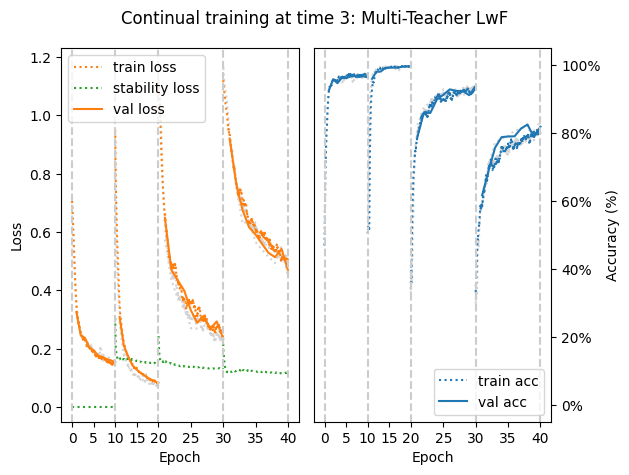

Multi-teacher lwf at t=3 evaluation on test set of all tasks:
['Pullover', 'Dress']: 81.79%
(baseline: 50.64%)
['Trouser', 'Bag']: 97.17%
(baseline: 49.37%)
['Ankle boot', 'Sneaker', 'Sandal']: 81.68%
(baseline: 52.56%)
['T-shirt/top', 'Coat', 'Shirt']: 81.39%
(baseline: 82.96%)

 +++ AVERAGE TASK TEST ACCURACY: 85.51% +++ 


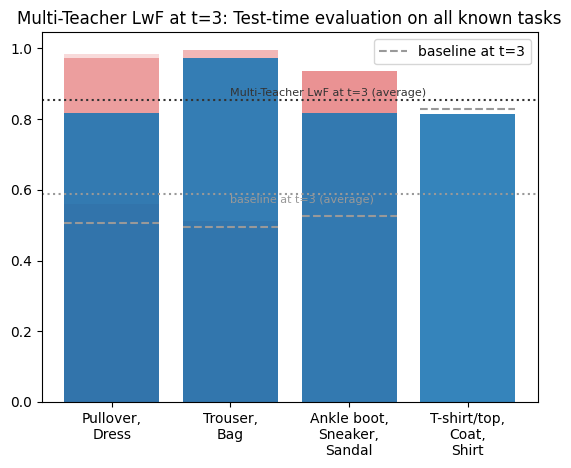


=== LwF (multi-teacher) final avg test acc: 85.51% ===


In [ ]:
import copy
import math
import torch.nn.functional as F

# ---------- Hyperparameters for multi-teacher LwF ----------
stability_weight = 1.0          # lambda_o: how strongly to enforce stability (scale of KD loss)
temperature = 5.0               # T for distillation (you used 5 earlier)
teacher_combination = 'confidence'  # 'uniform' or 'confidence'
ema_alpha = 0.9999                # EMA decay for the auxiliary teacher (close to 1 -> slow updates)
use_negative_entropy_conf = True # if True use -entropy as confidence; else use max-softmax

# ---------- Helpers ----------
def clone_model_to_device(model, device):
    """Deep copy a model and put on device, set eval and disable grads."""
    m = copy.deepcopy(model)
    m.to(device)
    m.eval()
    for p in m.parameters():
        p.requires_grad = False
    return m

def teacher_confidence_from_logits(logits, temperature=1.0, use_neg_entropy=True):
    """Return a per-example confidence scalar from logits.
       - use_neg_entropy True -> return negative entropy (higher => more confident)
       - otherwise return max softmax probability (higher => more confident)
       logits: (batch, classes)
    """
    probs = torch.softmax(logits / temperature, dim=1)
    if use_neg_entropy:
        # Negative entropy: -sum p log p  (higher -> more confident / peaky)
        ent = -torch.sum(probs * torch.log(probs + 1e-12), dim=1)  # shape (batch,)
        return -ent  # we return negative entropy so "higher" = more confident
    else:
        return torch.max(probs, dim=1)[0]  # max-prob per example

# ---------- Initialize LwF model & teacher storage ----------
torch.manual_seed(0)
lwf_backbone = Conv4Backbone()
lwf_multitask_model = MultitaskModel(lwf_backbone)

# storage for previously saved teachers (exemplar-free)
prev_snapshot = None   # Teacher A (exact snapshot of previous model)
prev_ema_snapshot = None  # Teacher B (EMA snapshot from previous task training)

# ---------- Training setup ----------
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(lwf_multitask_model.parameters(), lr=lr, weight_decay=l2_reg)

metrics = TrainingMetrics()
lwf_prev_test_accs = []

total_train_steps = int(sum([epochs_per_timestep * math.ceil(len(train_set)/BATCH_SIZE)
                                 for (train_set, val_set) in timestep_tasks.values()]))

# Outer loop over each task
for t, (task_train, task_val) in timestep_tasks.items():
    print(f'Training on task id: {t}  (classes: {task_train.classes})')

    # add task head if needed
    if t not in lwf_multitask_model.task_heads:
        task_head = TaskHead(num_classes = task_train.num_classes)
        lwf_multitask_model.add_task(t, task_head)

    # build dataloaders
    train_loader = utils.data.DataLoader(task_train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = utils.data.DataLoader(task_val,   batch_size=BATCH_SIZE, shuffle=True)

    # ---------- Prepare an EMA model that will be updated during this task's training.
    # The EMA model at the end of this task will become prev_ema_snapshot for the next task.
    ema_model = clone_model_to_device(lwf_multitask_model, device)
    # Note: clone_model_to_device sets requires_grad=False for ema_model params.

    # --- inner loop for this task ---
    lwf_multitask_model.train()
    for e in range(epochs_per_timestep):
        batch_iter = tqdm(train_loader, ncols=100) if show_progress else train_loader

        for step, batch in enumerate(batch_iter):
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)
            opt.zero_grad()

            # ensure batch is single-task (TIL assumption)
            assert torch.all(task_ids == task_ids[0]), "mismatching task IDs within batch"
            task_id = task_ids[0]

            # Forward for current task
            student_pred_for_newtask = lwf_multitask_model(x, task_id)
            hard_loss = loss_fn(student_pred_for_newtask, y)
            batch_acc = top1_acc(student_pred_for_newtask, y)

            # ---------- Multi-teacher stability loss (only if there are previous tasks) ----------
            if (prev_snapshot is None) and (prev_ema_snapshot is None):
                stab_loss = torch.tensor(0.0, device=device)
            else:
                # compute current features once
                curr_features = lwf_multitask_model.backbone(x)

                per_task_losses = []
                for prev_task in range(t):  # for every previous task head
                    # Student logits for that old task (current backbone -> old head)
                    student_logits = lwf_multitask_model.task_heads[str(prev_task)](curr_features)  # (batch, C_prev)

                    # Teacher A (snapshot)
                    if prev_snapshot is not None:
                        prev_features_A = prev_snapshot.backbone(x)   # note: each teacher has its own backbone
                        teacherA_logits = prev_snapshot.task_heads[str(prev_task)](prev_features_A)
                        lossA = distillation_output_loss(student_logits, teacherA_logits, temperature)  # (batch,)
                    else:
                        lossA = None

                    # Teacher B (EMA)
                    if prev_ema_snapshot is not None:
                        prev_features_B = prev_ema_snapshot.backbone(x)
                        teacherB_logits = prev_ema_snapshot.task_heads[str(prev_task)](prev_features_B)
                        lossB = distillation_output_loss(student_logits, teacherB_logits, temperature)  # (batch,)
                    else:
                        lossB = None

                    # Combine teachers
                    if (lossA is not None) and (lossB is not None):
                        if teacher_combination == 'uniform':
                            combined = 0.5 * lossA + 0.5 * lossB
                        elif teacher_combination == 'confidence':
                            # compute per-example confidences (higher => more trust)
                            confA = teacher_confidence_from_logits(teacherA_logits, temperature=temperature,
                                                                   use_neg_entropy=use_negative_entropy_conf)  # (batch,)
                            confB = teacher_confidence_from_logits(teacherB_logits, temperature=temperature,
                                                                   use_neg_entropy=use_negative_entropy_conf)
                            # normalize to [0,1] per-example weights
                            wA = confA / (confA + confB + 1e-12)
                            wB = 1.0 - wA
                            combined = wA * lossA + wB * lossB  # elementwise (batch,)
                        else:
                            raise ValueError("teacher_combination must be 'uniform' or 'confidence'")
                    elif (lossA is not None):
                        combined = lossA
                    elif (lossB is not None):
                        combined = lossB
                    else:
                        # no teachers available for this task (shouldn't happen)
                        combined = torch.zeros(x.shape[0], device=device)

                    # averaged over batch for this previous task:
                    per_task_losses.append(combined)  # each entry is (batch,)

                # stack per-task (num_prev_tasks, batch) -> mean across tasks then mean across batch
                per_task_stack = torch.stack(per_task_losses, dim=0)  # (num_prev_tasks, batch)
                # average across tasks -> (batch,)
                per_example_combined = per_task_stack.mean(dim=0)
                # final stability loss as mean over batch
                stab_loss = per_example_combined.mean()

            # ---------- Total loss (hard + stability) ----------
            total_loss = hard_loss + stability_weight * stab_loss

            total_loss.backward()
            opt.step()

            # update EMA model parameters (in-place)
            with torch.no_grad():
                for ema_p, p in zip(ema_model.parameters(), lwf_multitask_model.parameters()):
                    ema_p.data.mul_(ema_alpha).add_(p.data * (1.0 - ema_alpha))

            # Logging
            metrics.log_train(loss=hard_loss.item(),
                              acc=batch_acc,
                              stability_loss=stab_loss.item() if isinstance(stab_loss, torch.Tensor) else float(stab_loss))

            if show_progress:
                batch_iter.set_description(f'E{e} loss={total_loss.item():.3f} acc={batch_acc:.2%}')

        # End of epoch validation logging
        val_loss, val_acc = evaluate_model(lwf_multitask_model, val_loader, loss_fn)
        metrics.log_val(loss=val_loss, acc=val_acc)
        epoch_train_loss, epoch_val_loss = metrics.epoch_loss
        epoch_train_acc, epoch_val_acc = metrics.epoch_acc
        print(f'epoch:{e}/{epochs_per_timestep} | loss: {epoch_train_loss:.4f} | val_loss:{epoch_val_loss:.4f}  ' +
              f'acc: {epoch_train_acc:.2%} | val_acc: {epoch_val_acc:.2%}')

    # ---------- End of this CL iteration: save teachers for next tasks ----------
    metrics.next_iteration()
    metrics.plot(title=f'Continual training at time {t}: Multi-Teacher LwF', live=False,
                 max_step=total_train_steps, baseline_metrics=baseline_metrics)

    # Evaluate on tasks so far
    lwf_task_test_accs = full_test_evaluate(lwf_multitask_model, task_test_sets[:t+1],
                                            model_name=f'Multi-Teacher LwF at t={t}',
                                            prev_accs=lwf_prev_test_accs,
                                            baseline_taskwise_accs=baseline_prev_test_accs[t],
                                            verbose=True)
    lwf_prev_test_accs.append(lwf_task_test_accs)

    # Save the snapshot model (teacher A)
    prev_snapshot = clone_model_to_device(lwf_multitask_model, device)

    # Save the EMA model (teacher B) - clone to freeze it too
    prev_ema_snapshot = clone_model_to_device(ema_model, device)

# final metrics
lwf_avg_test_acc = np.mean(lwf_task_test_accs)
print(f'\n=== LwF (multi-teacher) final avg test acc: {lwf_avg_test_acc:.2%} ===')



Training on task id: 0  (classes: ['Pullover', 'Dress'])


E0 loss=0.307 acc=95.37%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.82it/s]


epoch:0/10 | loss: 0.4632 | val_loss:0.3261  acc: 83.75% | val_acc: 92.60%


E1 loss=0.260 acc=93.52%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.61it/s]


epoch:1/10 | loss: 0.2722 | val_loss:0.2482  acc: 94.86% | val_acc: 95.65%


E2 loss=0.226 acc=95.37%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 16.54it/s]


epoch:2/10 | loss: 0.2369 | val_loss:0.2244  acc: 95.40% | val_acc: 96.20%


E3 loss=0.210 acc=95.83%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.12it/s]


epoch:3/10 | loss: 0.2142 | val_loss:0.2375  acc: 95.74% | val_acc: 93.62%


E4 loss=0.199 acc=95.37%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.55it/s]


epoch:4/10 | loss: 0.1920 | val_loss:0.1930  acc: 96.69% | val_acc: 96.47%


E5 loss=0.150 acc=98.61%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.58it/s]


epoch:5/10 | loss: 0.1751 | val_loss:0.1791  acc: 97.16% | val_acc: 96.61%


E6 loss=0.173 acc=97.22%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.58it/s]


epoch:6/10 | loss: 0.1702 | val_loss:0.1760  acc: 97.02% | val_acc: 96.58%


E7 loss=0.158 acc=97.22%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.63it/s]


epoch:7/10 | loss: 0.1607 | val_loss:0.1633  acc: 96.97% | val_acc: 96.35%


E8 loss=0.133 acc=99.07%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 17.97it/s]


epoch:8/10 | loss: 0.1531 | val_loss:0.1612  acc: 97.07% | val_acc: 96.70%


E9 loss=0.185 acc=94.91%: 100%|█████████████████████████████████████| 40/40 [00:02<00:00, 18.42it/s]


epoch:9/10 | loss: 0.1552 | val_loss:0.1586  acc: 96.72% | val_acc: 96.48%


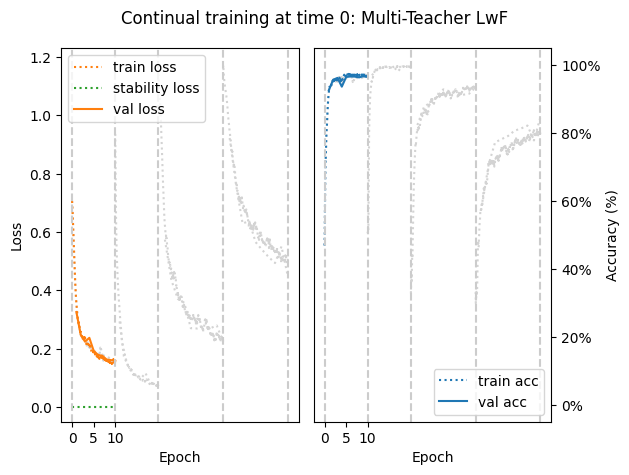

Multi-teacher lwf at t=0 evaluation on test set of all tasks:
['Pullover', 'Dress']: 97.79%
(baseline: 98.44%)

 +++ AVERAGE TASK TEST ACCURACY: 97.79% +++ 


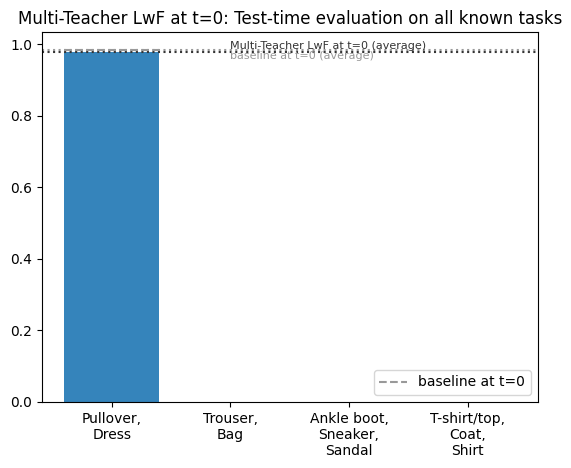

Training on task id: 1  (classes: ['Trouser', 'Bag'])


E0 loss=0.473 acc=95.83%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.21it/s]


epoch:0/10 | loss: 0.4765 | val_loss:0.3385  acc: 83.37% | val_acc: 94.40%


E1 loss=0.379 acc=98.15%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.17it/s]


epoch:1/10 | loss: 0.2596 | val_loss:0.2218  acc: 97.39% | val_acc: 97.67%


E2 loss=0.314 acc=100.00%: 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.22it/s]


epoch:2/10 | loss: 0.1905 | val_loss:0.1749  acc: 98.67% | val_acc: 98.05%


E3 loss=0.290 acc=99.54%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.20it/s]


epoch:3/10 | loss: 0.1483 | val_loss:0.1355  acc: 99.00% | val_acc: 99.11%


E4 loss=0.273 acc=99.54%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.21it/s]


epoch:4/10 | loss: 0.1255 | val_loss:0.1400  acc: 99.26% | val_acc: 98.17%


E5 loss=0.289 acc=97.69%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.18it/s]


epoch:5/10 | loss: 0.1139 | val_loss:0.1152  acc: 99.41% | val_acc: 99.23%


E6 loss=0.265 acc=98.61%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.19it/s]


epoch:6/10 | loss: 0.1108 | val_loss:0.1211  acc: 99.07% | val_acc: 98.37%


E7 loss=0.232 acc=100.00%: 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.15it/s]


epoch:7/10 | loss: 0.0986 | val_loss:0.0974  acc: 99.48% | val_acc: 99.50%


E8 loss=0.275 acc=98.15%: 100%|█████████████████████████████████████| 40/40 [00:05<00:00,  7.15it/s]


epoch:8/10 | loss: 0.0970 | val_loss:0.0943  acc: 99.24% | val_acc: 99.34%


E9 loss=0.222 acc=100.00%: 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.15it/s]


epoch:9/10 | loss: 0.0894 | val_loss:0.0891  acc: 99.42% | val_acc: 99.57%


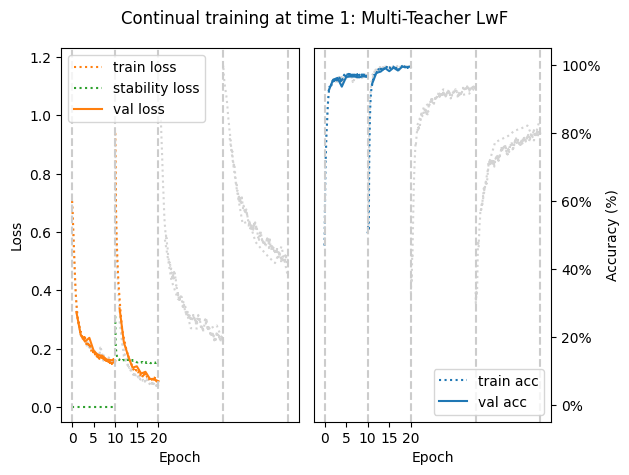

Multi-teacher lwf at t=1 evaluation on test set of all tasks:
['Pullover', 'Dress']: 97.66%
(baseline: 49.37%)
['Trouser', 'Bag']: 99.61%
(baseline: 99.74%)

 +++ AVERAGE TASK TEST ACCURACY: 98.63% +++ 


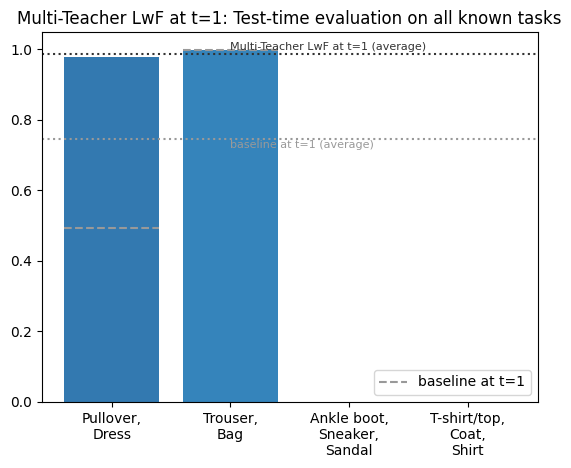

Training on task id: 2  (classes: ['Ankle boot', 'Sneaker', 'Sandal'])


E0 loss=0.818 acc=82.14%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.62it/s]


epoch:0/10 | loss: 0.8540 | val_loss:0.6731  acc: 67.49% | val_acc: 75.34%


E1 loss=0.658 acc=87.76%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.68it/s]


epoch:1/10 | loss: 0.5499 | val_loss:0.4796  acc: 83.31% | val_acc: 85.16%


E2 loss=0.622 acc=86.73%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.71it/s]


epoch:2/10 | loss: 0.4618 | val_loss:0.4033  acc: 86.63% | val_acc: 89.11%


E3 loss=0.545 acc=89.29%: 100%|█████████████████████████████████████| 60/60 [00:11<00:00,  5.45it/s]


epoch:3/10 | loss: 0.4030 | val_loss:0.3995  acc: 88.79% | val_acc: 89.31%


E4 loss=0.502 acc=92.86%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.58it/s]


epoch:4/10 | loss: 0.3382 | val_loss:0.3207  acc: 91.22% | val_acc: 91.55%


E5 loss=0.529 acc=89.80%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.66it/s]


epoch:5/10 | loss: 0.3201 | val_loss:0.3020  acc: 91.46% | val_acc: 91.89%


E6 loss=0.497 acc=91.33%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.64it/s]


epoch:6/10 | loss: 0.3056 | val_loss:0.3289  acc: 91.52% | val_acc: 90.14%


E7 loss=0.446 acc=93.37%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.62it/s]


epoch:7/10 | loss: 0.2812 | val_loss:0.2631  acc: 92.10% | val_acc: 92.68%


E8 loss=0.391 acc=95.92%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.64it/s]


epoch:8/10 | loss: 0.2559 | val_loss:0.2647  acc: 93.19% | val_acc: 92.33%


E9 loss=0.406 acc=92.86%: 100%|█████████████████████████████████████| 60/60 [00:10<00:00,  5.66it/s]


epoch:9/10 | loss: 0.2380 | val_loss:0.2092  acc: 93.72% | val_acc: 94.58%


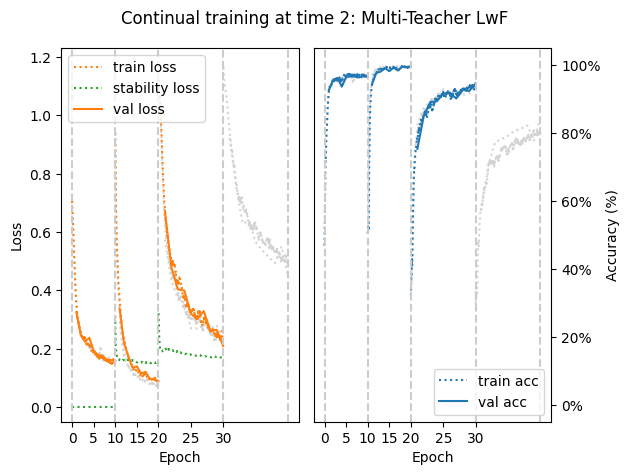

Multi-teacher lwf at t=2 evaluation on test set of all tasks:
['Pullover', 'Dress']: 81.30%
(baseline: 59.53%)
['Trouser', 'Bag']: 51.11%
(baseline: 51.11%)
['Ankle boot', 'Sneaker', 'Sandal']: 94.37%
(baseline: 92.81%)

 +++ AVERAGE TASK TEST ACCURACY: 75.59% +++ 


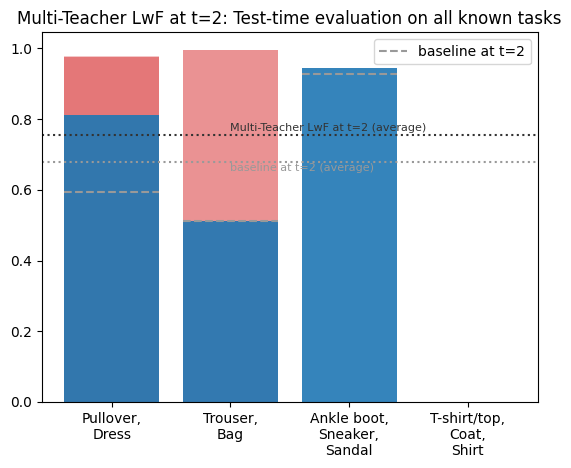

Training on task id: 3  (classes: ['T-shirt/top', 'Coat', 'Shirt'])


E0 loss=1.050 acc=56.12%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:0/10 | loss: 0.9639 | val_loss:0.8364  acc: 56.59% | val_acc: 69.53%


E1 loss=0.832 acc=74.49%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.72it/s]


epoch:1/10 | loss: 0.7696 | val_loss:0.7111  acc: 69.24% | val_acc: 71.92%


E2 loss=0.784 acc=76.02%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:2/10 | loss: 0.6696 | val_loss:0.6589  acc: 73.80% | val_acc: 72.90%


E3 loss=0.755 acc=73.98%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:3/10 | loss: 0.6392 | val_loss:0.6176  acc: 74.22% | val_acc: 76.76%


E4 loss=0.703 acc=80.10%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]


epoch:4/10 | loss: 0.6002 | val_loss:0.5635  acc: 76.01% | val_acc: 79.10%


E5 loss=0.643 acc=82.14%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]


epoch:5/10 | loss: 0.5740 | val_loss:0.5481  acc: 77.14% | val_acc: 78.81%


E6 loss=0.620 acc=82.14%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:6/10 | loss: 0.5512 | val_loss:0.5144  acc: 77.79% | val_acc: 80.96%


E7 loss=0.640 acc=79.59%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:7/10 | loss: 0.5256 | val_loss:0.4791  acc: 78.99% | val_acc: 83.64%


E8 loss=0.570 acc=82.65%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.71it/s]


epoch:8/10 | loss: 0.5147 | val_loss:0.5439  acc: 79.46% | val_acc: 77.64%


E9 loss=0.588 acc=81.12%: 100%|█████████████████████████████████████| 60/60 [00:12<00:00,  4.70it/s]


epoch:9/10 | loss: 0.4984 | val_loss:0.4507  acc: 80.07% | val_acc: 82.71%


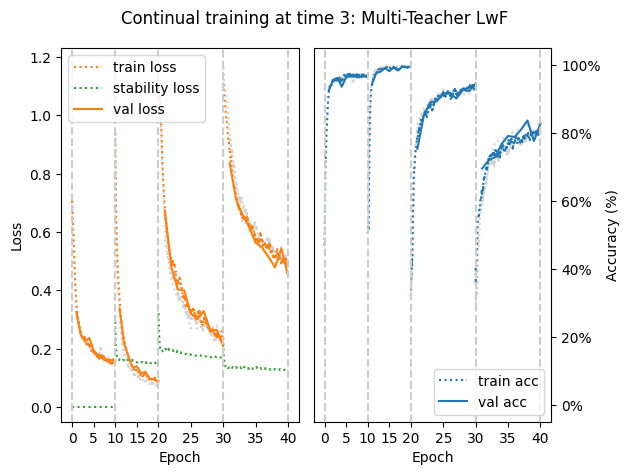

Multi-teacher lwf at t=3 evaluation on test set of all tasks:
['Pullover', 'Dress']: 96.38%
(baseline: 50.64%)
['Trouser', 'Bag']: 97.93%
(baseline: 49.37%)
['Ankle boot', 'Sneaker', 'Sandal']: 79.85%
(baseline: 52.56%)
['T-shirt/top', 'Coat', 'Shirt']: 83.73%
(baseline: 82.96%)

 +++ AVERAGE TASK TEST ACCURACY: 89.47% +++ 


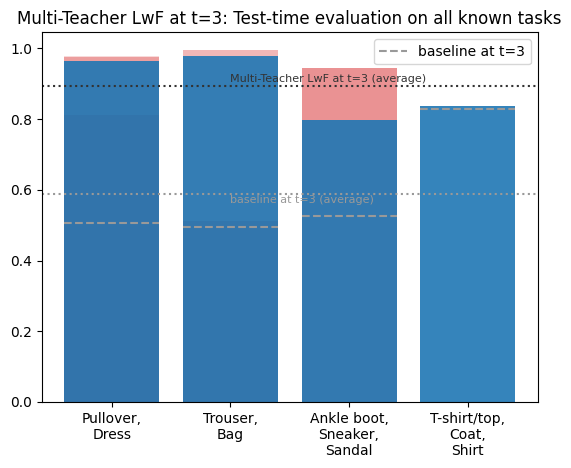


=== LwF (multi-teacher) final avg test acc: 89.47% ===


In [ ]:
import copy
import math
import torch.nn.functional as F

# ---------- Hyperparameters for multi-teacher LwF ----------
stability_weight = 1.0          # lambda_o: how strongly to enforce stability (scale of KD loss)
temperature = 5.0               # T for distillation (you used 5 earlier)
teacher_combination = 'confidence'  # 'uniform' or 'confidence'
ema_alpha = 0.9999                # EMA decay for the auxiliary teacher (close to 1 -> slow updates)
use_negative_entropy_conf = True # if True use -entropy as confidence; else use max-softmax

# ---------- Helpers ----------
def clone_model_to_device(model, device):
    """Deep copy a model and put on device, set eval and disable grads."""
    m = copy.deepcopy(model)
    m.to(device)
    m.eval()
    for p in m.parameters():
        p.requires_grad = False
    return m

def teacher_confidence_from_logits(logits, temperature=1.0, use_neg_entropy=True):
    """Return a per-example confidence scalar from logits.
       - use_neg_entropy True -> return negative entropy (higher => more confident)
       - otherwise return max softmax probability (higher => more confident)
       logits: (batch, classes)
    """
    probs = torch.softmax(logits / temperature, dim=1)
    if use_neg_entropy:
        # Negative entropy: -sum p log p  (higher -> more confident / peaky)
        ent = -torch.sum(probs * torch.log(probs + 1e-12), dim=1)  # shape (batch,)
        return -ent  # we return negative entropy so "higher" = more confident
    else:
        return torch.max(probs, dim=1)[0]  # max-prob per example

# ---------- Initialize LwF model & teacher storage ----------
torch.manual_seed(0)
lwf_backbone = Conv4Backbone()
lwf_multitask_model = MultitaskModel(lwf_backbone)

# storage for previously saved teachers (exemplar-free)
prev_snapshot = None   # Teacher A (exact snapshot of previous model)
prev_ema_snapshot = None  # Teacher B (EMA snapshot from previous task training)

# ---------- Training setup ----------
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(lwf_multitask_model.parameters(), lr=lr, weight_decay=l2_reg)

metrics = TrainingMetrics()
lwf_prev_test_accs = []

total_train_steps = int(sum([epochs_per_timestep * math.ceil(len(train_set)/BATCH_SIZE)
                                 for (train_set, val_set) in timestep_tasks.values()]))

# Outer loop over each task
for t, (task_train, task_val) in timestep_tasks.items():
    print(f'Training on task id: {t}  (classes: {task_train.classes})')

    # add task head if needed
    if t not in lwf_multitask_model.task_heads:
        task_head = TaskHead(num_classes = task_train.num_classes)
        lwf_multitask_model.add_task(t, task_head)

    # build dataloaders
    train_loader = utils.data.DataLoader(task_train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = utils.data.DataLoader(task_val,   batch_size=BATCH_SIZE, shuffle=True)

    # ---------- Prepare an EMA model that will be updated during this task's training.
    # The EMA model at the end of this task will become prev_ema_snapshot for the next task.
    ema_model = clone_model_to_device(lwf_multitask_model, device)
    # Note: clone_model_to_device sets requires_grad=False for ema_model params.

    # --- inner loop for this task ---
    lwf_multitask_model.train()
    for e in range(epochs_per_timestep):
        batch_iter = tqdm(train_loader, ncols=100) if show_progress else train_loader

        for step, batch in enumerate(batch_iter):
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)
            opt.zero_grad()

            # ensure batch is single-task (TIL assumption)
            assert torch.all(task_ids == task_ids[0]), "mismatching task IDs within batch"
            task_id = task_ids[0]

            # Forward for current task
            student_pred_for_newtask = lwf_multitask_model(x, task_id)
            hard_loss = loss_fn(student_pred_for_newtask, y)
            batch_acc = top1_acc(student_pred_for_newtask, y)

            # ---------- Multi-teacher stability loss (only if there are previous tasks) ----------
            if (prev_snapshot is None) and (prev_ema_snapshot is None):
                stab_loss = torch.tensor(0.0, device=device)
            else:
                # compute current features once
                curr_features = lwf_multitask_model.backbone(x)

                per_task_losses = []
                for prev_task in range(t):  # for every previous task head
                    # Student logits for that old task (current backbone -> old head)
                    student_logits = lwf_multitask_model.task_heads[str(prev_task)](curr_features)  # (batch, C_prev)

                    # Teacher A (snapshot)
                    if prev_snapshot is not None:
                        prev_features_A = prev_snapshot.backbone(x)   # note: each teacher has its own backbone
                        teacherA_logits = prev_snapshot.task_heads[str(prev_task)](prev_features_A)
                        lossA = distillation_output_loss(student_logits, teacherA_logits, temperature)  # (batch,)
                    else:
                        lossA = None

                    # Teacher B (EMA)
                    if prev_ema_snapshot is not None:
                        prev_features_B = prev_ema_snapshot.backbone(x)
                        teacherB_logits = prev_ema_snapshot.task_heads[str(prev_task)](prev_features_B)
                        lossB = distillation_output_loss(student_logits, teacherB_logits, temperature)  # (batch,)
                    else:
                        lossB = None

                    # Combine teachers
                    if (lossA is not None) and (lossB is not None):
                        if teacher_combination == 'uniform':
                            combined = 0.5 * lossA + 0.5 * lossB
                        elif teacher_combination == 'confidence':
                            # compute per-example confidences (higher => more trust)
                            confA = teacher_confidence_from_logits(teacherA_logits, temperature=temperature,
                                                                   use_neg_entropy=use_negative_entropy_conf)  # (batch,)
                            confB = teacher_confidence_from_logits(teacherB_logits, temperature=temperature,
                                                                   use_neg_entropy=use_negative_entropy_conf)
                            # normalize to [0,1] per-example weights
                            wA = confA / (confA + confB + 1e-12)
                            wB = 1.0 - wA
                            combined = wA * lossA + wB * lossB  # elementwise (batch,)
                        else:
                            raise ValueError("teacher_combination must be 'uniform' or 'confidence'")
                    elif (lossA is not None):
                        combined = lossA
                    elif (lossB is not None):
                        combined = lossB
                    else:
                        # no teachers available for this task (shouldn't happen)
                        combined = torch.zeros(x.shape[0], device=device)

                    # averaged over batch for this previous task:
                    per_task_losses.append(combined)  # each entry is (batch,)

                # stack per-task (num_prev_tasks, batch) -> mean across tasks then mean across batch
                per_task_stack = torch.stack(per_task_losses, dim=0)  # (num_prev_tasks, batch)
                # average across tasks -> (batch,)
                per_example_combined = per_task_stack.mean(dim=0)
                # final stability loss as mean over batch
                stab_loss = per_example_combined.mean()

            # ---------- Total loss (hard + stability) ----------
            total_loss = hard_loss + stability_weight * stab_loss

            total_loss.backward()
            opt.step()

            # update EMA model parameters (in-place)
            with torch.no_grad():
                for ema_p, p in zip(ema_model.parameters(), lwf_multitask_model.parameters()):
                    ema_p.data.mul_(ema_alpha).add_(p.data * (1.0 - ema_alpha))

            # Logging
            metrics.log_train(loss=hard_loss.item(),
                              acc=batch_acc,
                              stability_loss=stab_loss.item() if isinstance(stab_loss, torch.Tensor) else float(stab_loss))

            if show_progress:
                batch_iter.set_description(f'E{e} loss={total_loss.item():.3f} acc={batch_acc:.2%}')

        # End of epoch validation logging
        val_loss, val_acc = evaluate_model(lwf_multitask_model, val_loader, loss_fn)
        metrics.log_val(loss=val_loss, acc=val_acc)
        epoch_train_loss, epoch_val_loss = metrics.epoch_loss
        epoch_train_acc, epoch_val_acc = metrics.epoch_acc
        print(f'epoch:{e}/{epochs_per_timestep} | loss: {epoch_train_loss:.4f} | val_loss:{epoch_val_loss:.4f}  ' +
              f'acc: {epoch_train_acc:.2%} | val_acc: {epoch_val_acc:.2%}')

    # ---------- End of this CL iteration: save teachers for next tasks ----------
    metrics.next_iteration()
    metrics.plot(title=f'Continual training at time {t}: Multi-Teacher LwF', live=False,
                 max_step=total_train_steps, baseline_metrics=baseline_metrics)

    # Evaluate on tasks so far
    lwf_task_test_accs = full_test_evaluate(lwf_multitask_model, task_test_sets[:t+1],
                                            model_name=f'Multi-Teacher LwF at t={t}',
                                            prev_accs=lwf_prev_test_accs,
                                            baseline_taskwise_accs=baseline_prev_test_accs[t],
                                            verbose=True)
    lwf_prev_test_accs.append(lwf_task_test_accs)

    # Save the snapshot model (teacher A)
    prev_snapshot = clone_model_to_device(lwf_multitask_model, device)

    # Save the EMA model (teacher B) - clone to freeze it too
    prev_ema_snapshot = clone_model_to_device(ema_model, device)

# final metrics
lwf_avg_test_acc = np.mean(lwf_task_test_accs)
print(f'\n=== LwF (multi-teacher) final avg test acc: {lwf_avg_test_acc:.2%} ===')



### Assessment

If your implementation works, the performance of the CL model should be more-or-less comparable with the baseline on each new task, but much higher on the average of all tasks!

Once you're happy with it, you should report your results as usual:

* Show **a few plots** demonstrating your LwF implementation and how your model avoids forgetting performance on previous tasks, comparing its final test accuracy to that of the baseline model.
    
* Also write **a few sentences** summarising any particular issues you ran into, how you solved them, and any other insights you gained about designing/implementing your CL algorithm.

Good luck! If you have any problems, especially regarding understanding the task-incremental learning setting or the intuition behind the LwF algorithm, don't hesitate to ask for help.